> # <center> Data-jutsu 🥷: Navigating Otaku Trends and Insights <center/>


<div style="text-align: center; padding: 20px;">

<h2> Introduction <img src='https://i.imgur.com/yz2BIFo.png' width=50 padding=1><h2/>
<br><br/>

<img src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExaHkzb3Z4YjBnM255dm1yc2I3anlmYXZxOTFqZWRpc3B6Z3FkZTlqZCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/XI4lQ4b1PNRDbkyxss/giphy.gif" alt="Alt Text" width=700>
        
</div>
<br> <br/>


Welcome to the next phase of our data journey through the world of anime! In the previous section, we delved deep into the intricate details of various anime titles, uncovering insights into their production, popularity, and genre dynamics. Now, we're embarking on a new adventure as we shift our focus to explore the behaviors and preferences of anime enthusiasts like yourself.




### 🔴**Project Objective:**
In this user-based analysis, our primary objective is to understand the anime fandom from a different perspective. Rather than scrutinizing individual anime titles, we'll delve into the diverse characteristics and tendencies of anime fans themselves. Our exploration will revolve around key user variables such as `age`, `favorite genres`, and `gender` comparisons, among others.


>🔴This section will provide answers to the previously posed questions as well as address additional inquiries that arise
 - 1. what is the perfered genre for males and females respectivly ?
 - 2. how much does the average anime fan spend watching anime (Days)?
 - 3. Which anime titles rank as the top 10 most rewatched among users?
 - 4. At what point in time did the platform witness an increase in its anime fanbase?(year)

### 📌**Data Source:**
 

- 📃**Description :**  

    - The dataset comprises two CSV files, each providing valuable insights into the behaviors and preferences of anime enthusiasts on the MyAnimeList platform. These files contain detailed user information, including attributes such as birthday, gender, nickname, and scoring per anime, along with aggregated statistics for each user. Additionally, this data encompasses `731,290 users` in total, ordered by their MyAnimeList (MAL) `ID`, from the oldest and first account registered to the latest, spanning the timeframe from `2004` to `2007`.  

        -  `users-details-2023.csv` ➡️ comprises information on 731,290 users registered on the MyAnimeList platform with their personal information such as `Age` , `Date joined` , `Gender` and so on . 

        - `users-score-2023.csv`  ➡️ This dataset comprises anime scores provided by 270,033 users, resulting in a total of 24,325,191 rows   
        
        



- 🔗**Link**: MyAnimeList Dataset on [Kaggle](https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset)







> ### **<center> 🔄️Import Required Libraries <center/>**

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import time
import re
import concurrent.futures
import logging
import warnings
import os
import zipfile
from io import BytesIO

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing


import dask.dataframe as dd
from IPython.display import HTML
from cycler import cycler

plt.style.use('code/dark.mplstyle')
# Disable debug messages from Matplotlib
logging.getLogger('matplotlib').setLevel(logging.WARNING)

warnings.filterwarnings("ignore")


> ### **<center>  ⚙️Helper Functions <center/>**
<center> Writing functions to simplify certain repetitive tasks. <center/>

In [4]:
#                                  [ HELPER FUNCTIONS WHICH WILL BE USED LATER ON THE ANALYSIS ]


# READ THE CSV FILE (x) CHUNKS AT A TIME FOR MEMORY EFFICANCY 
def read_csv_to_chunks(file_path, chunk_size,dropped_column, indexColumn=None):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size,index_col=indexColumn):  
        # Process the chunk or append it directly to the list
        if dropped_column is not None:
            chunk.drop(dropped_column, axis=1)

        chunks.append(chunk)
    return pd.concat(chunks)

# FUNCTION TO EXTRACT EACH USER'S AGE AND PERFORM CALCULATIONS IF NEEDED .
def calculate_date(birthdate):
    """Calculates age in years, handling invalid dates and missing values."""
    if pd.isna(birthdate):
        return None  # Return None for missing values

    today = datetime.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age



 # EXTRACT THE CITY/COUNTRY FROM LOCATION COLUMN.
def extract_location(text):
    country_pattern = r"[\w\s]+,\s\w+"  # Matches "Country, State" format
    city_pattern = r"\w+(?:[\s-]\w+)*"  # Matches city names with optional separators
    match = re.search(country_pattern, text)
    if match:
        return match.group(0).split(",")[0].strip()  # Extract country
    match = re.search(city_pattern, text)
    if match:
        return match.group(0).strip()  # Extract city
    return None  # Return None if no match

# FORMATTER TICKERS TO HANDLE MILLIONS AND Ks 
def dynamic_formatter(x, pos):
            magnitude = 0
            while abs(x) >= 1000:
                magnitude += 1
                x /= 1000.0
            return '{:.0f}{}'.format(x, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

def million_formatter(x, pos):
    if x == 0:
        return '0'
    elif x >= 1000000:
        return '{:.1f}M'.format(x / 1000000)
    else:
        return '{:.0f}K'.format(x / 1000)


def find_outliers(dataset, index):
    # EXCLUDE CATEGORICAL COLUMNS FROM THE Z-SCORE TEST 
    numerical_columns = dataset.columns.difference(index)
    
    # COMPUTE Z-SCORE FOR NUMERICAL COLUMNS.
    z_scores = dataset[numerical_columns].apply(stats.zscore)
    
    # FIND OUTLIERS USING Z-SCORE TEST WITH THRESHOLD OF 3
    outliers = dataset[(np.abs(z_scores) > 3).any(axis=1)]
    
    return outliers


# LISTED ALL THE DIRECTORY OF THE NEEDED CSV FILES.
file_path = ['CSV/users-details-2023.csv' ,'CSV/users-score-2023.csv' ,'CSV/anime-filtered.csv']

>### **<center> 🛠️Load & Clean Data <center/>**
**<center> Loading the Dataset <center/>**

- ###### The csv files containg the data will be read into 1000 chunks at a time for memory effeciancy 
- ###### Will drop unecessary columns for The analysis .
- ###### Then , the 2 data sets will be converted to a pandas dataframe for further processing 
- ###### We will inspect the two dataframes by printing the `head()` (first 5 rows of the Dataframe)

In [3]:
user1 = read_csv_to_chunks(file_path[0], 1000, dropped_column=None)
print(user1.shape)
user1.head(731289)

(731290, 16)


,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
0,1,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,8.0,93.0,64.0,399.0,60.0,8458.0
1,3,Aokaado,Male,NaN,"Oslo, Norway",2004-11-11T00:00:00+00:00,68.6,7.34,23.0,137.0,99.0,44.0,40.0,343.0,15.0,4072.0
2,4,Crystal,Female,NaN,"Melbourne, Australia",2004-11-13T00:00:00+00:00,212.8,6.68,16.0,636.0,303.0,0.0,45.0,1000.0,10.0,12781.0
3,9,Arcane,NaN,NaN,NaN,2004-12-05T00:00:00+00:00,30.0,7.71,5.0,54.0,4.0,3.0,0.0,66.0,0.0,1817.0
4,18,Mad,NaN,NaN,NaN,2005-01-03T00:00:00+00:00,52.0,6.27,1.0,114.0,10.0,5.0,23.0,153.0,42.0,3038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731284,1291079,Dybido,Male,NaN,NaN,2012-05-06T00:00:00+00:00,41.0,8.48,2.0,88.0,7.0,5.0,33.0,135.0,0.0,3317.0
731285,1291083,Dolopa,NaN,NaN,NaN,2012-05-06T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731286,1291085,alenrobnik,NaN,NaN,NaN,2012-05-06T00:00:00+00:00,21.4,8.22,16.0,58.0,9.0,1.0,42.0,126.0,0.0,1239.0
731287,1291087,Oblongata,NaN,1993-01-30T00:00:00+00:00,NaN,2012-05-06T00:00:00+00:00,51.3,7.53,38.0,175.0,0.0,9.0,211.0,433.0,2.0,3010.0


In [4]:
user1.drop(columns=['On Hold',
                    'Dropped', 'Plan to Watch',
                    'Mal ID' ], inplace=True)

In [5]:
#user2 = pd.read_csv('CSV/users-score-2023.csv', index_col=[4])
user2 = read_csv_to_chunks(file_path[1], 1000, dropped_column=None, indexColumn=[4])


In [6]:
print(user2.shape)
user2.head()

(1048575, 4)


,Username,anime_id,Anime Title,rating
NaN,Xinil,21,One Piece,9
NaN,Xinil,48,.hack//Sign,7
NaN,Xinil,320,A Kite,5
NaN,Xinil,49,Aa! Megami-sama!,8
NaN,Xinil,304,Aa! Megami-sama! Movie,8


In [7]:
user1 = user1.merge(user2, on='Username', how='left')
user1.head()

,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,Total Entries,Rewatched,Episodes Watched,anime_id,Anime Title,rating
0,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,399.0,60.0,8458.0,21.0,One Piece,9.0
1,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,399.0,60.0,8458.0,48.0,.hack//Sign,7.0
2,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,399.0,60.0,8458.0,320.0,A Kite,5.0
3,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,399.0,60.0,8458.0,49.0,Aa! Megami-sama!,8.0
4,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,399.0,60.0,8458.0,304.0,Aa! Megami-sama! Movie,8.0


In [8]:
user1 = user1.dropna(subset=['Anime Title', 'anime_id'])
user1['anime_id'].astype(int)

0            21
1            48
2           320
3            49
4           304
           ... 
1048658    1797
1048659    1798
1048660    1051
1048661     937
1048662    1488
Name: anime_id, Length: 1045274, dtype: int32

Merged our two Dataframes `user1` , and `user2` after keeping only valid columns for the analysis . 

In [9]:
anime_genre = read_csv_to_chunks(file_path[2], 1000, dropped_column=None)

anime_genre = anime_genre[['Genres', 'anime_id']]

We need to add the genre of each anime the user has rated , thus we used one of the previous datasets `anime-filtered` to achive this.

In [10]:
anime_genre.head()

,Genres,anime_id
0,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1
1,"Action, Drama, Mystery, Sci-Fi, Space",5
2,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",6
3,"Action, Mystery, Police, Supernatural, Drama, ...",7
4,"Adventure, Fantasy, Shounen, Supernatural",8


In [11]:
user = user1.merge(anime_genre, on='anime_id')
user.head()

,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,Total Entries,Rewatched,Episodes Watched,anime_id,Anime Title,rating,Genres
0,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,399.0,60.0,8458.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,..."
1,vondur,Male,1988-01-25T00:00:00+00:00,"Bergen, Norway",2005-01-05T00:00:00+00:00,73.1,8.06,11.0,94.0,138.0,7.0,4374.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,..."
2,Amuro,NaN,1988-02-22T00:00:00+00:00,Canada,2005-01-23T00:00:00+00:00,142.5,7.41,20.0,298.0,392.0,0.0,8565.0,21.0,One Piece,7.0,"Action, Adventure, Comedy, Super Power, Drama,..."
3,Cruzle,Male,1983-11-09T00:00:00+00:00,NaN,2005-04-14T00:00:00+00:00,78.0,7.18,30.0,135.0,204.0,15.0,4694.0,21.0,One Piece,8.0,"Action, Adventure, Comedy, Super Power, Drama,..."
4,jaames,Male,NaN,"Seattle, Washington",2005-04-30T00:00:00+00:00,12.5,8.71,3.0,16.0,19.0,0.0,745.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,..."


🔼merged all the changes into one final dataframe `user` to set the dataframe ready for further analysis .  

---

> #### <center> **Inspecting The Data** <center/>

  - ###### <center> We'll examine the data's shape, column count, and search for any inconsistencies or significant areas to address during the cleaning process.<center/>
  - ###### <center> We will be also looking for any null values and try to impute these rows <center/>

In [12]:
print(f'user shape : {user.shape}' , '\n')
print(f'user columns : {user.columns}', '\n')

print(f'NULL VALUES :\n {user.isnull().sum()}')

user shape : (1036523, 16) 

user columns : Index(['Username', 'Gender', 'Birthday', 'Location', 'Joined', 'Days Watched',
       'Mean Score', 'Watching', 'Completed', 'Total Entries', 'Rewatched',
       'Episodes Watched', 'anime_id', 'Anime Title', 'rating', 'Genres'],
      dtype='object') 

NULL VALUES :
 Username                 0
Gender              206298
Birthday            490939
Location            393201
Joined                   0
Days Watched             0
Mean Score               0
Watching                 0
Completed                0
Total Entries            0
Rewatched                0
Episodes Watched         0
anime_id                 0
Anime Title              0
rating                   0
Genres                   0
dtype: int64


The data consists of `1036523 ` rows and `16` columns with having null values in these columns : `Gender` , `Birthday` , `Location` . 

> 📌*On the MyAnimeList Platform, providing information such as gender, birthdate, and location is typically optional, which means it's common for these columns to contain some missing values.*


In [13]:
user.info()
user.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036523 entries, 0 to 1036522
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Username          1036523 non-null  object 
 1   Gender            830225 non-null   object 
 2   Birthday          545584 non-null   object 
 3   Location          643322 non-null   object 
 4   Joined            1036523 non-null  object 
 5   Days Watched      1036523 non-null  float64
 6   Mean Score        1036523 non-null  float64
 7   Watching          1036523 non-null  float64
 8   Completed         1036523 non-null  float64
 9   Total Entries     1036523 non-null  float64
 10  Rewatched         1036523 non-null  float64
 11  Episodes Watched  1036523 non-null  float64
 12  anime_id          1036523 non-null  float64
 13  Anime Title       1036523 non-null  object 
 14  rating            1036523 non-null  float64
 15  Genres            1036523 non-null  object 
dtype

,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,Total Entries,Rewatched,Episodes Watched,anime_id,Anime Title,rating,Genres
count,1036523,830225,545584,643322,1036523,1.036523e+06,1.036523e+06,1.036523e+06,1.036523e+06,1.036523e+06,1.036523e+06,1.036523e+06,1.036523e+06,1036523,1.036523e+06,1036523
unique,8665,3,2553,2175,497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11036,NaN,4215
top,trafagibr,Male,1985-09-05T00:00:00+00:00,Canada,2007-06-28T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fullmetal Alchemist,NaN,"Action, Adventure, Comedy, Super Power, Supern..."
freq,2976,547583,2950,12810,10703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4492,NaN,9248
mean,NaN,NaN,NaN,NaN,NaN,1.362039e+02,7.454619e+00,2.238353e+01,4.602136e+02,6.259613e+02,3.253503e+01,8.391402e+03,6.582701e+03,NaN,7.475987e+00,NaN
std,NaN,NaN,NaN,NaN,NaN,1.196807e+02,7.804725e-01,5.184196e+01,5.052097e+02,6.271160e+02,1.021996e+02,9.590654e+03,1.054211e+04,NaN,1.647497e+00,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,NaN,1.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,NaN,5.730000e+01,6.970000e+00,4.000000e+00,1.410000e+02,2.130000e+02,0.000000e+00,3.399000e+03,4.170000e+02,NaN,7.000000e+00,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.040000e+02,7.460000e+00,9.000000e+00,2.930000e+02,4.310000e+02,5.000000e+00,6.246000e+03,1.624000e+03,NaN,8.000000e+00,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.811000e+02,7.940000e+00,2.000000e+01,5.930000e+02,8.460000e+02,2.800000e+01,1.106800e+04,6.875000e+03,NaN,9.000000e+00,NaN


so far , The Data  seems to have none invalid values except for Null rows .
> 🔬👀 Here's an interesting find: "Fullmetal Alchemist" is the most prevalent anime in this dataset, and it's also the highest scored anime we discovered in the previous section.

In [14]:
user = user.dropna(subset=['anime_id', 'Anime Title', 'Username'])

🔼Dropped duplicated columns  
 
---


>### **<center> 🛠️Load & Clean Data <center/>**
**<center> Clean The Dataset <center/>**

- ###### <center> Once identifying the type of missing data, proceed with imputing null values. <center/>
- ###### <center> Address inconsistent data types for cleaning purposes.<center/>
- ###### <center> Extract significant attributes such as `age` and valid `locations`, creating new columns as needed.<center/>

In [15]:
# IMPUTING NUMERICAL(FLOAT) COLUMNS WITH THEIR MEAN .
filled_columns = ['Mean Score', 'Episodes Watched', 'Days Watched', 'Watching', 'Completed', 'Total Entries', 'Rewatched' , 'rating']
for col in filled_columns:
    user[col].fillna(user[col].mean())
    user[col].astype('int')

user['Genres'] = user['Genres'].replace('Unknown', np.nan)


🔼 After categorizing each column based on the appropriate type of missingness, we will proceed with imputing the data for those columns.
(**all the above columns are MCAR data**)  
 
---

> <center> Handle Data Types & Extract  User Age . <center/>

In [16]:
user['Birthday'].dtypes
user['Birthday'].tail(10000)

1026523    1987-09-16T00:00:00+00:00
1026524                          NaN
1026525    1981-10-18T00:00:00+00:00
1026526    1990-08-06T00:00:00+00:00
1026527                          NaN
                     ...            
1036518    1992-07-06T00:00:00+00:00
1036519    1992-07-06T00:00:00+00:00
1036520    1992-07-06T00:00:00+00:00
1036521    1992-07-06T00:00:00+00:00
1036522    1983-04-25T00:00:00+00:00
Name: Birthday, Length: 10000, dtype: object

> Time Sreies Data 

it is noted that the `Birthday` , and `joined` datatype is `Object` when it should be assigned to `datatime` . 


In [17]:
# SETTING UP DATES COLUMNS INTO DATETIME TYPE:
user['Birthday'] = pd.to_datetime(user['Birthday'], errors='coerce')
user['Joined'] = pd.to_datetime(user['Joined'],errors='coerce')

# IMPUTING BIRTHDAY COLUMN :
user['Birthday'].fillna(user['Birthday'].mean(), inplace=True)

🔼Assigned each column to an appropirate dataype   

---


> ###### <center> Extracting User Age <center/>
Below , we will split the dataset into two halfs , then we will proceed with applying our pre defined function `calculate_date()` on each half to reduce time and memory usage . 

In [18]:
# SPLIT DATAFRAME TO HALFS (2) TO SAVE MEMORY AND TIME #
# ----------------------------------------------------------#

# first half
half1 = user.iloc[:len(user)//2]
# second half
half2 = user.iloc[len(user)//2:]

In [19]:
# Apply the function to each half
half1['Age'] = half1['Birthday'].apply(calculate_date)
half2['Age'] = half2['Birthday'].apply(calculate_date)

# Concatenate the results back together
result = pd.concat([half1, half2])

After applying our function we need to make sure that all ages are valid within the dataset. we will do so by printing all inlogical ages that might be present in the data set (people with ages older than 90 , and younger than 1 years old )

In [20]:
print(result[(result['Age'] > 90) | (result['Age'] < 1)].count(),'\n')
user = result

print(f' MIN VALUE: {user['Birthday'].min()}')
print(f'MAX VALUE: {user['Birthday'].max()}')
user.info()

Username            4060
Gender              3158
Birthday            4060
Location            2488
Joined              4060
Days Watched        4060
Mean Score          4060
Watching            4060
Completed           4060
Total Entries       4060
Rewatched           4060
Episodes Watched    4060
anime_id            4060
Anime Title         4060
rating              4060
Genres              4060
Age                 4060
dtype: int64 

 MIN VALUE: 1930-01-01 00:00:00+00:00
MAX VALUE: 2021-12-01 00:00:00+00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036523 entries, 0 to 1036522
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   Username          1036523 non-null  object             
 1   Gender            830225 non-null   object             
 2   Birthday          1036523 non-null  datetime64[ns, UTC]
 3   Location          643322 non-null   object             
 4   J

> 🔴Looking at the data above, it appers that 4854 out of 713564 user has invalid birthdates . **Representig approxmetally  0.7% of the Dataset** . Usually on MyAnimeList There are many spam accounts who uses fake birthdays such as dates from the future , another example there are users who would not prefer disclouse their  actual age and ending up using un logical dates instead.

> ###### <center>filter and impute invalid age values<center/>

In [21]:
# FIRST - INSPECT THE COLUMN 
user['Birthday'].head()

0             1985-03-04 00:00:00+00:00
1             1988-01-25 00:00:00+00:00
2             1988-02-22 00:00:00+00:00
3             1983-11-09 00:00:00+00:00
4   1987-09-24 06:28:56.841236736+00:00
Name: Birthday, dtype: datetime64[ns, UTC]

In [22]:
# INSPECT THE NUMBER OF NULL VALUES
user['Age'].isnull().sum()

0

In [23]:

print(user[['Joined']].describe())  # Check summary statistics
print(user[['Joined']].min())  # Print minimum values
print(user[['Joined']].max())  # Print maximum values



                                    Joined
count                              1036523
mean   2007-05-22 05:14:53.797822720+00:00
min              2004-11-05 00:00:00+00:00
25%              2007-04-17 00:00:00+00:00
50%              2007-06-24 00:00:00+00:00
75%              2007-08-05 00:00:00+00:00
max              2007-09-12 00:00:00+00:00
Joined   2004-11-05 00:00:00+00:00
dtype: datetime64[ns, UTC]
Joined   2007-09-12 00:00:00+00:00
dtype: datetime64[ns, UTC]


In [24]:
user['Birthday'].isnull().sum()

0

> 📌Based on our domain knowledge and information gathered from [this forum on MyAnimeList](https://myanimelist.net/forum/?topicid=1940405), it's nearly impossible to validate the actual age of each user. As we observed in the dataset earlier, some users exploited the optional nature of the age field by entering unrealistic birthdates. For our project's purposes, we will establish a reasonable age range and filter the column accordingly.

In [25]:
#                                                                   .. STARTING THE CLEANING PROCESS ..
# ----------------------------     
                                           
# SETTING THE AGE RANGE :
#       WE CHOOSE A RANGE OF 13 YEARS OLD (MIN) - AND 70 YEARS OLD (MAX)
min_allowed_year = 1954
min_allowed_age = 13
max_allowed_age = 70

today_date = pd.Timestamp.today().date()  # Extract only the date
# Filter out rows with birthdates before 1900 and ages below 13 or above the maximum
min_allowed_year = 1900
min_allowed_age = 13
max_allowed_age = 120  # Adjust as needed
user = user[(user['Birthday'].dt.year >= min_allowed_year) &
            (user['Age'] >= min_allowed_age) &
            (user['Age'] <= max_allowed_age)]


today_date = pd.Timestamp.today().date()
user['Birthday'] = user['Birthday'].dt.date
user['Joined'] = user['Joined'].dt.date  # Not currently used for age calculation

user['Age'] = ((today_date - user['Birthday'].to_numpy()) / pd.Timedelta(days=365.25)).astype(int)


In [26]:
# APPLY CALCULATION TO THE AGE COLUMN:
user.loc[user['Age'].isna(), 'Age'] = ((user['Joined'].to_numpy() - user['Birthday'].to_numpy()) / pd.Timedelta(days=365.25)).astype(int)


In [27]:
# INSPECT THE COLUMN TO CHECK THE RESULTS:
user['Age'].head(1000000)


0          39
1          36
2          36
3          40
4          36
           ..
1002557    36
1002558    94
1002559    36
1002560    48
1002561    36
Name: Age, Length: 1000000, dtype: int32

> ######  <center>Defining age categories<center/>  
below , we will split our age column into 3 main age groups(teen, adult , elder) to make the analysis smoother . 

In [28]:
# Define age ranges
teen_range = (13, 19)
adult_range = (20, 59)
elder_range = (60, user['Age'].max())

# Create new columns for age categories
user['Teen'] = user['Age'].apply(lambda x: 1 if teen_range[0] <= x <= teen_range[1] else 0)
user['Adult'] = user['Age'].apply(lambda x: 1 if adult_range[0] <= x <= adult_range[1] else 0)
user['Elder'] = user['Age'].apply(lambda x: 1 if elder_range[0] <= x <= elder_range[1] else 0)

# Display the modified DataFrame
print(user.head())


  Username Gender    Birthday             Location      Joined  Days Watched  \
0    Xinil   Male  1985-03-04           California  2004-11-05         142.3   
1   vondur   Male  1988-01-25       Bergen, Norway  2005-01-05          73.1   
2    Amuro    NaN  1988-02-22               Canada  2005-01-23         142.5   
3   Cruzle   Male  1983-11-09                  NaN  2005-04-14          78.0   
4   jaames   Male  1987-09-24  Seattle, Washington  2005-04-30          12.5   

   Mean Score  Watching  Completed  Total Entries  Rewatched  \
0        7.37       1.0      233.0          399.0       60.0   
1        8.06      11.0       94.0          138.0        7.0   
2        7.41      20.0      298.0          392.0        0.0   
3        7.18      30.0      135.0          204.0       15.0   
4        8.71       3.0       16.0           19.0        0.0   

   Episodes Watched  anime_id Anime Title  rating  \
0            8458.0      21.0   One Piece     9.0   
1            4374.0      21.

> ##### <center> Clean Gender & Location columns <center/>

We will start off by inspecting the two columns looking for (null values , count , top value) .

In [29]:
print(f'OVERALL INFO :\n {user['Gender'].describe(include="all")}')
print(f'NULL VALUES:\n {user['Gender'].isnull().sum()}')
user['Gender'].value_counts()


OVERALL INFO :
 count     828358
unique         3
top         Male
freq      545716
Name: Gender, dtype: object
NULL VALUES:
 205453


Gender
Male          545716
Female        278190
Non-Binary      4452
Name: count, dtype: int64

In [30]:
print(f'OVERALL INFO :\n {user['Location'].describe(include="all")}')
print(f'NULL VALUES:\n {user['Location'].isnull().sum()}')
user['Location'].value_counts()

OVERALL INFO :
 count     641039
unique      2173
top       Canada
freq       12810
Name: Location, dtype: object
NULL VALUES:
 392772


Location
Canada                    12810
Germany                   12717
Israel                    10984
California                 9654
Sweden                     8575
                          ...  
Turkey                        1
windsor,ns                    1
MAlaysia                      1
Qu&eacute;bec / Canada        1
Trinity County, CA            1
Name: count, Length: 2173, dtype: int64

In [31]:
user.isnull().sum()

Username                 0
Gender              205453
Birthday                 0
Location            392772
Joined                   0
Days Watched             0
Mean Score               0
Watching                 0
Completed                0
Total Entries            0
Rewatched                0
Episodes Watched         0
anime_id                 0
Anime Title              0
rating                   0
Genres                  31
Age                      0
Teen                     0
Adult                    0
Elder                    0
dtype: int64

In [32]:
user['Gender'].isnull().sum()
user['Location'].isnull().sum()

user['Gender'].value_counts()

Gender
Male          545716
Female        278190
Non-Binary      4452
Name: count, dtype: int64

> Upon examining the two columns, we discovered the following:

- The Gender column contains a total of `828,358` entries, with `205,453` being null values, equating to `61.24%` of the data being missing.

- The Location column contains a total of `641,039` entries, with `392,772` being null values, representing `24.78%` of the data being missing.

Considering that both location and gender are pivotal to our analysis, discarding such a substantial portion of missing values could potentially introduce bias to the dataset. Therefore, we will employ alternative imputation methods for each column to address this issue.

 We will be using The MICE imputation method to impute the Gender column 
 > 💡 MICE imputation reduces bias, preserves relationships between variables, and is particularly useful for large datasets with missing data.<br><br/>

- ###### <center> we need to encode the categorical 'Gender' variable into numerical values using a `LabelEncoder`. This allows us to work with numerical representations of the genders in our dataset. <center/>
- ######  <center> then ,  we identify missing values and map them to NaN (Not a Number) for ease of handling during imputation. <center/>

-  ###### <center> We then employ an IterativeImputer, a method that estimates missing values by modeling each feature with missing entries as a function of other features  <center/>
- ###### <center> fit the imputer to the data, we impute missing values for the 'Gender' column along with other relevant columns ('Age' and 'Completed') using the IterativeImputer's transform function. The imputed numerical values for 'Gender' are rounded to integers to maintain consistency. <center/>

- ######  <center> After that , we will inverse the imputation by decoding the numerical values asssigned to the gender column , and assign them back to a valid cateogrical values after imputation . <center/>

In [33]:
# INITLIZE LABEL ENCODER
le = preprocessing.LabelEncoder()

# DEFINE COLUMN NAMES FOR IMPUTATION (THE GEDNER COLUMN )
impute_col = 'Gender'
#NAMING OUR ENCODED COLUMN (GENDER_NO)
impute_col_encoded = 'Gender_no'

In [34]:
# FIT LabelEncoder TO GENDER COLUMN.
le.fit(user.loc[:, impute_col])

LabelEncoder()

In [35]:
# PRINT THE ENCODED VALUES FOR EACH CLAS
print(f'Gender VALUES ENCODED : \n{dict(zip(le.classes_, le.transform(le.classes_)))}')

# ENCODE Gender COLUMN AND STORE THE ENCODED VALUES IN A NEW COLUMN
user[impute_col_encoded] = le.transform(user[impute_col])

# Display the last 1000 rows of the dataset including the original Gender and the encoded Gender(GENDER_NO)
user[['Username', 'Gender', 'Gender_no']].tail(1000)

Gender VALUES ENCODED : 
{'Female': 0, 'Male': 1, 'Non-Binary': 2, nan: 3}


,Username,Gender,Gender_no
1035522,Sakucita,Female,0
1035523,Red_Devil,Female,0
1035524,Red_Devil,Female,0
1035525,Red_Devil,Female,0
1035526,AN1M3NIAC,Female,0
...,...,...,...
1036518,Rahkshilord,Male,1
1036519,Rahkshilord,Male,1
1036520,Rahkshilord,Male,1
1036521,Rahkshilord,Male,1


In [36]:
# MAP ENCODED VALUES TO NAN IF THEY REPRESENT MISSING VALUES 
user[impute_col_encoded] = user[impute_col_encoded].map(lambda x: np.nan if x == 3 else x )

In [26]:
#  CHECK THE FIRST FEW ROWS WHERE GENDER_NO IS NAN 
user[user['Gender_no'].isna()].head()

,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,Total Entries,...,Episodes Watched,anime_id,Anime Title,rating,Genres,Age,Teen,Adult,Elder,Gender_no
2,Amuro,NaN,1988-02-22,Canada,2005-01-23,142.5,7.41,20.0,298.0,392.0,...,8565.0,21.0,One Piece,7.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,NaN
8,loklo,NaN,1987-09-24,NaN,2005-06-24,15.2,7.82,2.0,25.0,34.0,...,905.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,NaN
9,Phony2,NaN,1987-09-24,NaN,2005-06-25,180.9,7.61,20.0,391.0,493.0,...,10843.0,21.0,One Piece,8.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,NaN
20,sugaryfluff,NaN,1987-09-24,NaN,2005-11-12,30.7,7.77,8.0,70.0,108.0,...,1839.0,21.0,One Piece,7.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,NaN
22,flink,NaN,1987-09-24,NaN,2006-03-09,76.4,8.11,7.0,197.0,248.0,...,4723.0,21.0,One Piece,8.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,NaN


In [37]:
# INITIALIZE IterativeImputer FOR IMPUTATION 
imputer = IterativeImputer(random_state=100)

# SELECT COLUMNS FOR IMPUTATION 
user_train = user.loc[:, ['Age' , impute_col_encoded, 'Completed']]
# FIT  IterativeImputer ON THE SELECTED COLUMNS   
imputer.fit(user_train)

IterativeImputer(random_state=100)

In [38]:
# IMPUTE MISSING VALUES 
IterativeImputer(random_state=100)
user_imputed = imputer.transform(user_train)

user_imputed[:10]
# ROUND IMPUTED VALUES
user_imputed[:,1].round()

array([1., 1., 1., ..., 1., 1., 0.])

In [39]:
# UPDATE THE GENDER_NO COLUMN WITH THE ROUNDED IMPUTED VALUES 
user.loc[:,[impute_col_encoded]] = user_imputed[:,1].round()
# DISPLY THE FIRST 10 ROWS OF THE DATASET AFTER IMPUTATION 
user.head(10)

,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,Total Entries,...,Episodes Watched,anime_id,Anime Title,rating,Genres,Age,Teen,Adult,Elder,Gender_no
0,Xinil,Male,1985-03-04,California,2004-11-05,142.3,7.37,1.0,233.0,399.0,...,8458.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",39,0,1,0,1.0
1,vondur,Male,1988-01-25,"Bergen, Norway",2005-01-05,73.1,8.06,11.0,94.0,138.0,...,4374.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
2,Amuro,NaN,1988-02-22,Canada,2005-01-23,142.5,7.41,20.0,298.0,392.0,...,8565.0,21.0,One Piece,7.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
3,Cruzle,Male,1983-11-09,NaN,2005-04-14,78.0,7.18,30.0,135.0,204.0,...,4694.0,21.0,One Piece,8.0,"Action, Adventure, Comedy, Super Power, Drama,...",40,0,1,0,1.0
4,jaames,Male,1987-09-24,"Seattle, Washington",2005-04-30,12.5,8.71,3.0,16.0,19.0,...,745.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
5,marvin_9martian,Female,1987-09-24,Canada,2005-05-10,36.4,6.66,4.0,57.0,125.0,...,2187.0,21.0,One Piece,10.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,0.0
6,sorairo,Male,1987-09-24,Latvia,2005-05-12,50.5,6.09,1.0,114.0,158.0,...,2974.0,21.0,One Piece,1.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
7,luffykun,Male,1983-06-09,"London,England",2005-06-17,72.6,8.77,2.0,125.0,128.0,...,4329.0,21.0,One Piece,10.0,"Action, Adventure, Comedy, Super Power, Drama,...",40,0,1,0,1.0
8,loklo,NaN,1987-09-24,NaN,2005-06-24,15.2,7.82,2.0,25.0,34.0,...,905.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
9,Phony2,NaN,1987-09-24,NaN,2005-06-25,180.9,7.61,20.0,391.0,493.0,...,10843.0,21.0,One Piece,8.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0


In [40]:
#                                     ----- INVERSING THE IMPUTATION (DECODING NUMERICAL VALUES BACK TO GENDER VALUES) -----


# DECODE THE IMPUTED GENDER VALUES 
Gender_imputed = list(le.inverse_transform(user[impute_col_encoded].round().astype('int')))
# DISPLAY THE IMPUTED GENDER VALUES 
Gender_imputed[:2000000]

# UPDATE THE GENDER COLUMN WITH THE IMPUTED VALUES  
user['Gender'] = Gender_imputed
user


,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,Total Entries,...,Episodes Watched,anime_id,Anime Title,rating,Genres,Age,Teen,Adult,Elder,Gender_no
0,Xinil,Male,1985-03-04,California,2004-11-05,142.3,7.37,1.0,233.0,399.0,...,8458.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",39,0,1,0,1.0
1,vondur,Male,1988-01-25,"Bergen, Norway",2005-01-05,73.1,8.06,11.0,94.0,138.0,...,4374.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
2,Amuro,Male,1988-02-22,Canada,2005-01-23,142.5,7.41,20.0,298.0,392.0,...,8565.0,21.0,One Piece,7.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
3,Cruzle,Male,1983-11-09,NaN,2005-04-14,78.0,7.18,30.0,135.0,204.0,...,4694.0,21.0,One Piece,8.0,"Action, Adventure, Comedy, Super Power, Drama,...",40,0,1,0,1.0
4,jaames,Male,1987-09-24,"Seattle, Washington",2005-04-30,12.5,8.71,3.0,16.0,19.0,...,745.0,21.0,One Piece,9.0,"Action, Adventure, Comedy, Super Power, Drama,...",36,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036518,Rahkshilord,Male,1992-07-06,NaN,2007-09-12,332.5,7.24,9.0,1557.0,1865.0,...,19613.0,39249.0,Pandora to Akubi,8.0,"Action, Fantasy, Shoujo",31,0,1,0,1.0
1036519,Rahkshilord,Male,1992-07-06,NaN,2007-09-12,332.5,7.24,9.0,1557.0,1865.0,...,19613.0,30912.0,Robot Girls Z Episode 0,7.0,"Comedy, Mecha, Parody",31,0,1,0,1.0
1036520,Rahkshilord,Male,1992-07-06,NaN,2007-09-12,332.5,7.24,9.0,1557.0,1865.0,...,19613.0,40630.0,Saga Incident,8.0,Music,31,0,1,0,1.0
1036521,Rahkshilord,Male,1992-07-06,NaN,2007-09-12,332.5,7.24,9.0,1557.0,1865.0,...,19613.0,33103.0,Zekkyou Gakkyuu: Tensei,3.0,"Horror, Shoujo, Supernatural",31,0,1,0,1.0


In [41]:
#CHECKING FOR ANY MISSING VALUES AFTER THE IMPUTATION:
user['Gender'].value_counts()
user['Gender'].isnull().sum()

0

> Cleaning Invalid Locations

- Inspect the column to look for (missing values - invalid values )

In [31]:
#FILTER LOCATION ROWS 
print(user['Location'].describe(include='all'))

print(f'NULL VALUES:\n{user['Location'].isnull().sum()}')

#print(user['Location'].value_counts())

count     641039
unique      2173
top       Canada
freq       12810
Name: Location, dtype: object
NULL VALUES:
392772


we have 2173 country/city in the dataset , of which 395910 are NULL values

In [42]:
user['Location'] = user['Location'].fillna('Unknown')

In [33]:
user['Location'].isnull().sum()

0

checking unique values in the column 

In [43]:
unique_location = user['Location'].unique()[:50]  # SELECT THE FIRST 50 LOCATIONS

for num, location in enumerate(unique_location):
    print(num, location)


0 California
1 Bergen, Norway
2 Canada
3 Unknown
4 Seattle, Washington
5 Latvia
6 London,England
7 Lule&aring;, Sweden
8 Ontario, Canada
9 UAE
10 Locked up in Shuuka basement working on cards :p
11 Tampere, Finland
12 Finland, Pori
13 Johor, Malaysia
14 Hamilton, Ontario
15 New York, NY
16 Interlaken, Bern, Switzerland
17 Beachwood, Ohio
18 Austin, Texas
19 U.S.
20 Sweden
21 WA, USA
22 greece
23 Carlisle, Pennsylvania
24 Kungsör
25 Southampton, United Kingdom
26 Oz
27 England, UK
28 Chair
29 In the shadows of mankind.
30 Portland, Oregon
31 Llanfairpwllgwyngyllgogerychwyrndrobwllllantysilio
32 La Mirada, California
33 Hallsberg, Sweden
34 Las Vegas, Nevada
35 Bakersfield,California
36 London, UK
37 Toronto, Ontario - Canada
38 Withdrawn into myself
39 France
40 Uppsala, Sweden
41 Toronto, Ontario
42 Sugar Land, Texas
43 Miami/WPB
44 Athens, Greece
45 United States
46 Louisville, KY
47 Indiana
48 Singapore
49 Minnesota


> 😐What is wrong with Otaku ?

🔼As noted above , we notice the presence of values such as `Dining In Hell, Tonight` , `Locked up in Shuuka basement working on cards :p` as an input for `Location` . 
> 💡As mentioned earlier , arrtiubtes such as `Location` , `Gender` , `Age(Birthdate)` are optional on **MyAnimeList** platform . It is expected to see such values , to fix this we will need to use different approach .   

---

> > **<center> Validating User Locations Using GeoNames API <center/>**
- split the column into two halfs 
- scan through each row , and make an API call to GeoNames API 
- if the location exsist in the API database , then it is valid , if not , will be labeled as `Unknown`

In [44]:
# --> IMPORT LOGGING MODULE FOR LOGGING MESSAGES (HELPS DEBUGING)
import concurrent.futures # -->  # IMPORT  concurrent.futures  FOR CONCURRENT EXECUTION (FOR MEMORY EFFECIANCY)
import requests # --> # IMPORT REQUESTS FOR MAKING HTTP REQUESTS 

import re 
import time

#username = "hazelishifs"
username = 'hifsapi_2'
valid_countries = ['Seattle, Washington',
                   'Latvia',
                   'London,England',
                   'Lule&aring;, Sweden',
                   'Ontario, Canada',
                   'UAE'] # --> LISTING RANDOM NUMBER OF VALID COUNTRIES TO HELP AVOID REPETITIVE API CALLS

# Regular expression pattern to filter out invalid locations
invalid_location_pattern = re.compile(
    r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF\U00002600-\U000026FF\U00002900-\U0000297F\U00002B50-\U00002B55\U000023F0-\U000023FF\U0001F000-\U0001F02F\U0001F0A0-\U0001F0FF\U0001F100-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF\U00002600-\U000026FF\U00002900-\U0000297F\U00002B50-\U00002B55\U000023F0-\U000023FF\U0001F000-\U0001F02F\U0001F0A0-\U0001F0FF\U0001F100-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF\U00002600-\U000026FF\U00002900-\U0000297F\U00002B50-\U00002B55\U000023F0-\U000023FF\U0001F000-\U0001F02F\U0001F0A0-\U0001F0FF\U0001F100-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002700-\U000027BF\U00002600-\U000026FF\U00002900-\U0000297F\U00002B50-\U00002B55\U000023F0-\U000023FF]')



def validate_location(location):
    """
    FUNCTION TO VALIDATE A LOCATION USING THE GeoNames API. 

    Args:
        LOCATION (str) : LOCATION STRING TO BE VALIDATED .

    Returns:
        TUPLE: A TUPLE CONTAINING THE VALIDATED LOCATION , LATITUDE , AND LONGITUDE. 
    """

    # Preprocess and normalize the location
    if any(country in location for country in valid_countries): # CHECKING IF THE LOCATION IS ALREADY IN (valid_location) LIST 
        return True, None, None  # Skip API call and consider the location valid

    base_url = "http://api.geonames.org/searchJSON"
    params = {
        "q": location,
        "maxRows": 1,
        "username": username,
        "lang": "en",  # --> INCLUDE ENGLISH LANGUAGE RESULTS ONLY 
    }

    try:
        response = requests.get(base_url, params=params)
        data = response.json()
        logging.debug(f"Location: {location}, API Response: {data}")

        # CHECK IF AT LEAST ONE RESULT IS RETURNED  
        if data.get("totalResultsCount", 0) > 0:
            # ANALYZE API RESPONSE FOR INDICATORS OF A VALID LOCATION 
            if any("countryCode" in result for result in data.get("geonames", [])):
                return location, data['geonames'][0]['lat'], data['geonames'][0]['lng']
        # IF LOCATION IS INVALID OR API CALL FAILS, RETURN 'Unknown' 
        return 'Unknown', None, None

    except Exception as e:
        logging.error(f"Error in validate_location: {e}")
        return 'Unknown', None, None


def validate_chunk(chunk):
    """
    FUNCTION TO VALIDATE A CHUNK OF LOCATIONS.

    Args:
        chunk (DataFrame):  DATAFRAME CONTAINING LOCATIONS TO BE VALIDATED.

    Returns:
        DataFrame: DATAFRAME WITH VALIDATED LOCATIONS AND THEIR COORDINATES.
    """
    
    try:
        # FILTER OUT ROWS WITH 'Unknown' LOCATION
        chunk = chunk[chunk['Location'] != 'Unknown']

        # - CREATE A NEW DATAFRAME FOR THE RESULTS 
        #  - DROP DUPLICATES BASED ON `Location`.
        chunk = chunk.drop_duplicates(subset=['Location'])

        # GROUP LOCATIONS INTO BATCHES FOR API CALLS .
        batch_size = 5
        batched_locations = [
            chunk.iloc[i:i + batch_size]['Location'].tolist()
            for i in range(0, len(chunk), batch_size)
        ]

        # VALIDATE LOCATIONS IN BATCHES
        validated_locations = []
        for batch in batched_locations:
            for location in batch:
                validated_locations.append(validate_location(location))

        #  ADD VALIDATED LOCATIONS TO THE DATAFRAME.
        chunk['is_valid_location'], chunk['Latitude'], chunk['Longitude'] = zip(*validated_locations)

        # ASSIGN A DELAY TO AVOID HITTING THE API CALL LIMIT TOO QUICKLY.
        time.sleep(5)

        return chunk

    except Exception as e:
        logging.error(f"Error in validate_chunk: {e}")
        return None


# SET LOGGING LEVEL TO DEBUG FOR MORE DETAILED INFORMATION . 
#logging.basicConfig(level=logging.DEBUG)


# FILTER OUT ROWS WITH 'Unknown' LOCATION 
user = user[user['Location'] != 'Unknown']

# SPLIT THE DATA INTO TWO HALFS .
half1, half2 = np.array_split(user, 2)



In [45]:
# USE ThreadPoolExecutor FOR PARALLEL PROCESSING (LIMIT TIME AND  MEMORY USAGE TO HELP MAKE THE PROCESS SMOTTHER )
with concurrent.futures.ThreadPoolExecutor() as executor:

    futures = [executor.submit(validate_chunk, half) for half in [half1, half2]] # - > SUBMIT TASKS FOR BOTH HALVES 
    results = [] # -> CONCATENATE RESULTS FROM BOTH HALVES 

    for future in concurrent.futures.as_completed(futures):
        result_chunk = future.result()
        if result_chunk is not None:
            results.append(result_chunk)

# COMBINE RESULTS FROM BOTH HALVES 
final_result = pd.concat(results)



# MERGE THE VALIDATED LOCATIONS BACK INTO THE ORIGINAL DATAFRAME `USER`
user = pd.merge(user, final_result[['Location', 'Latitude', 'Longitude']], on=['Location'], how='left', suffixes=('_original', ''))

# PRINT THE UPDATED DATAFRAME (CONTAINS OUR VALIDATED LOCATION AND TWO NEW COLUMN (LATTIUDE AND MAGNITUDE ))
print(user)


ERROR:root:Error in validate_location: Expecting value: line 1 column 1 (char 0)
ERROR:root:Error in validate_location: Expecting value: line 1 column 1 (char 0)


            Username  Gender    Birthday                          Location  \
0              Xinil    Male  1985-03-04                        California   
1              Xinil    Male  1985-03-04                        California   
2             vondur    Male  1988-01-25                    Bergen, Norway   
3             vondur    Male  1988-01-25                    Bergen, Norway   
4              Amuro    Male  1988-02-22                            Canada   
...              ...     ...         ...                               ...   
1281071  Allografter    Male  1981-10-18                  Leeds/London, UK   
1281072  Allografter    Male  1981-10-18                  Leeds/London, UK   
1281073  Allografter    Male  1981-10-18                  Leeds/London, UK   
1281074         daya  Female  1983-04-25  somewhere outside of rome, italy   
1281075         daya  Female  1983-04-25  somewhere outside of rome, italy   

             Joined  Days Watched  Mean Score  Watching  Comple

to make sure we can clean as much as possiable locations , we will also deal with special charecters as a last step . 

In [46]:
# DEFINE REGEX PATTERNS TO DETECT SPECIAL CHARACTERS , EMOJIS , NUMBERS , AND ENSURE LENGTH LIMIT
special_char_pattern = re.compile(r'[^\w\s\d\U0001F300-\U0001F9FF]')
emoji_pattern = re.compile(r'[\U0001F300-\U0001F9FF]')
number_pattern = re.compile(r'\d')

# DEFINE REGEX PATTERNS TO DETECT SPECIFIC WORDS AND CHARACTERS INDICATING INVALID LOCATIONS 
invalid_word_pattern = re.compile(r'\b(Hentai|anywhere|somewhere|earth|mars|my)\b', flags=re.IGNORECASE)
invalid_char_pattern = re.compile(r'(:p|:P|3>|<3|XD|xd|\^\^)', flags=re.IGNORECASE)

length_limit = 40

def clean_location(location):
    # CHECK IF LOCATION CONTAINS SPECIAL CHARACTERS , EMOJIS , OR NUMBERS 
    if special_char_pattern.search(location) or emoji_pattern.search(location) or number_pattern.search(location):
        return "Unknown"
    
    # CHECK IF LOCATION LENGTH EXCEEDS THE LIMIT 
    if len(location) > length_limit:
        return "Unknown"
    
    # CHECK IF LOCATION CONTAINS INVALID WORDS OR CHARACTERS 
    if invalid_word_pattern.search(location) or invalid_char_pattern.search(location):
        return "Unknown"
    
    return location

# APPLY OUR PREDEFINED clean_location FUNCTION TO THE LOCATION COLUMN 
user['Location'] = user['Location'].apply(clean_location)


> ### **<center> 🔎 EDA & Visualization 📊<center/>**
In this section focused on EDA & Visualization, our aim is to glean insights and better understand the community of MyAnimeList users

> ##### <center> 👤Analyzing User Demographics <center/> 

Within this section, we will examine the general attributes of users, such as `Age` , `Gender` and `Location`, in order to gain a deeper comprehension of the anime fan community.

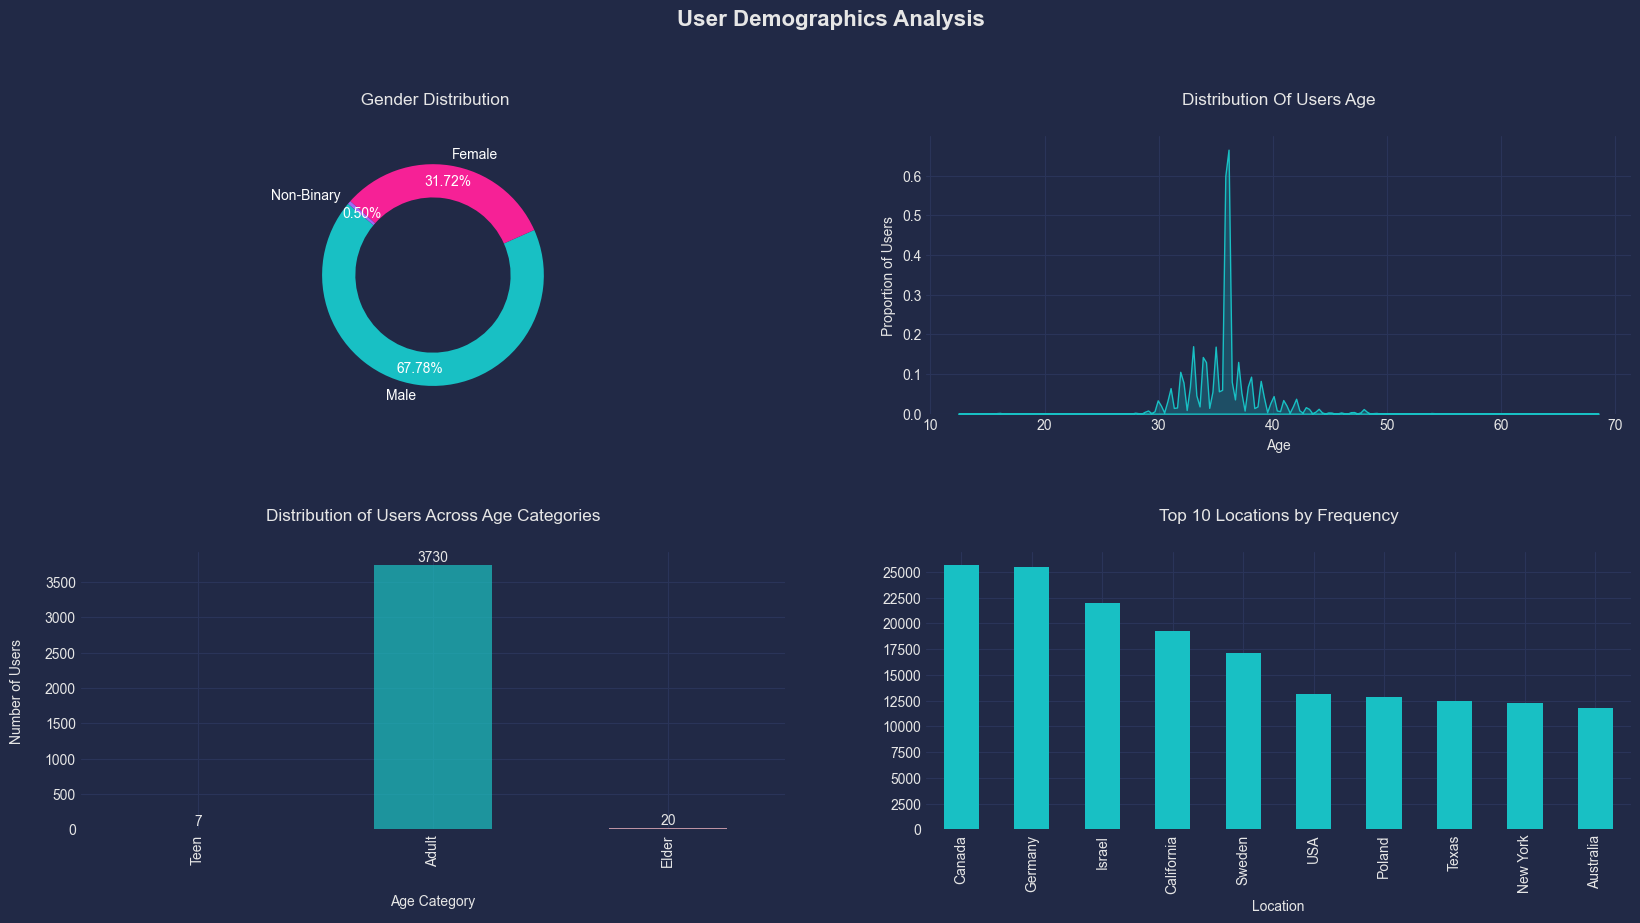

In [48]:
# CREATING THE FIGURE , AND THE SUBPLOT.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 9))

# FILTERING ONLY UNIQUE USERNAMES AND CALCULATING THE SUM OF THEIR AGE.
age_category_counts = user.groupby('Username')[['Teen', 'Adult', 'Elder']].max().sum() # SUM BY AGE CATEGORY

# FILTER UNREALISTIC/FAKE AGE.
user['Age'] = user['Age'].astype('int')
age_filtered = user[(user['Age'] >= 13) & (user['Age'] <= 80)]

# Apply extract_location to the 'Location' column of your DataFrame
#user['Location'] = user['Location'].apply(extract_location)

# Filter out "Unknown" values
user_filtered = user[user['Location'] != 'Unknown']

# Count the frequency of each location
filtered_countries = user_filtered['Location'].value_counts().sort_values(ascending=False).head(10)

# FILTERING GENDER
gender_filtered = user['Gender'].value_counts()

# PLOTTING THE GENDER DISTRIBUTION.
gender_filtered.plot(kind='pie', labels=gender_filtered.index, autopct='%1.2f%%', ax=ax1, pctdistance=0.85,
                     startangle=140, wedgeprops=dict(width=0.3), textprops=dict(color='white'), fontsize=10)

ax1.set_ylabel('')
ax1.set_title(' Gender Distribution', fontdict={'size': '12.4'}, verticalalignment='center',
              horizontalalignment='center', loc='center', y=1.10)

# PLOTTING KDE PLOT
sns.kdeplot(data=age_filtered, x='Age', fill=True, ax=ax2)
ax2.set_title('Distribution Of Users Age', fontdict={'size':'12.4'}, loc='center', verticalalignment='center', 
              horizontalalignment='center' , y=1.10)

ax2.set_ylabel('Proportion of Users')

# PLOTTING AGE CATEGORIES.
age_category_counts.plot(kind='bar', color=['#1b7989', '#1cc2c3', 'pink'],alpha=0.7, ax=ax3)
ax3.set_xlabel('Age Category', labelpad=20)
ax3.set_ylabel('Number of Users', labelpad=15)
ax3.set_title('Distribution of Users Across Age Categories', fontdict={ 'size':'12.4'}, loc='center', verticalalignment='center',
              horizontalalignment='center', y=1.10)

# PLOTTING TOP 10 LOCATIONS
filtered_countries.plot(kind='bar', ax=ax4)
ax4.set_title('Top 10 Locations by Frequency', fontdict={'size':'12.4'}, loc='center', verticalalignment='center', 
              horizontalalignment='center', y=1.10)

# FUNCTION TO ADJUST Y-LABEL TICKS.
def format_ticks(value, _):
    return f'{int(value):,}'

# Adjust y-axis ticks
for i, v in enumerate(age_category_counts):
    ax3.text(i, v + 10, str(int(v)), ha='center', va='bottom')



fig.suptitle('User Demographics Analysis',verticalalignment='center',fontsize=16, fontweight='bold', y=1.01)
plt.locator_params(axis='y', nbins=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)




Based on the observations provided:

1. **Gender Distribution**:
   - Males comprise more than half of the platform's users.
   - Females account for approximately 31.7%.
   - Non-binary individuals constitute a minority, comprising only 0.50% of the total.

2. **Age Distribution**:
   - Adults form the largest age group.
   - Elders follow in representation.
   - Teens make up the smallest age group, with only 7 members.

3. **Age with Most Users**:
   - Around age 35 has the highest user count, making up approximately 0.6% of the total.

4. **Location Distribution**:
   - North America and Europe emerge as the dominant continents.
   - Canada has the highest user count, exceeding 25,000 users, while Poland has the least with almost 12,500 users.
   - Asian countries and other continents are notably absent from the top 10 locations.

> 💡Contrary to the usual belief that anime appeals mainly to teens and kids: 
   Many adults are part of the fanbase.
   Elders also show considerable interest, while teens form a smaller part of anime enthusiasts.

In [49]:
import folium
from folium.plugins import MarkerCluster

# Filter out locations with the value "Unknown" and NaN latitude and longitude values
filtered_user = user[(user['Location'] != 'Unknown') & (~user['Latitude'].isna()) & (~user['Longitude'].isna())]

# Check if there are any valid locations
if len(filtered_user) > 0:
    # Create a Folium map centered around a location (e.g., first location in DataFrame)
    mymap = folium.Map(location=[filtered_user['Latitude'].iloc[0], filtered_user['Longitude'].iloc[0]], zoom_start=1)

    # Create marker cluster for top 10 locations
    top_10_cluster = MarkerCluster(name='Top 10 Locations').add_to(mymap)

    # Add markers for top 10 locations with different colors and sizes based on frequency
    for location, freq in filtered_user['Location'].value_counts().nlargest(10).items():
        location_data = filtered_user[filtered_user['Location'] == location]
        popup = f"{location} ({freq} entries)"
        folium.CircleMarker(location=[location_data['Latitude'].iloc[0], location_data['Longitude'].iloc[0]],
                            radius=freq*0.5, popup=popup, color='blue', fill=False, fill_opacity=0.6).add_to(top_10_cluster)

    # Create marker cluster for least 10 locations
    least_10_cluster = MarkerCluster(name='Least 10 Locations').add_to(mymap)

    # Add markers for least 10 locations with different colors and sizes based on frequency
    for location, freq in filtered_user['Location'].value_counts().nsmallest(10).items():
        location_data = filtered_user[filtered_user['Location'] == location]
        popup = f"{location} ({freq} entries)"
        folium.CircleMarker(location=[location_data['Latitude'].iloc[0], location_data['Longitude'].iloc[0]],
                            radius=freq*0.5, popup=popup, color='red', fill=True, fill_opacity=0.6).add_to(least_10_cluster)

    # Add a legend to the map
    folium.LayerControl().add_to(mymap)

    # Display the map
    mymap
else:
    print("No valid locations found to create the map.")
    print(filtered_user)
display(mymap)

> 💡🔴The map provided offers a clear visualization of the top 10 and least 10 frequent locations by users on the platform. With this interactive feature, users can easily navigate through the locations and gain a better understanding of the data. By clicking on the label in the top-right corner, you can filter in or out attributes such as "top 10 locations" or "least 10 location", enabling more focused analysis and exploration of the data.   

---

>  ##### **<center> Analyzing Joining Dates ⌛: Who is the oldest member ? <center/>**

We'll delve into the trend of user joinings over the years on the platform, along with examining the profiles of the three earliest users who joined, aiming to discern any notable patterns.

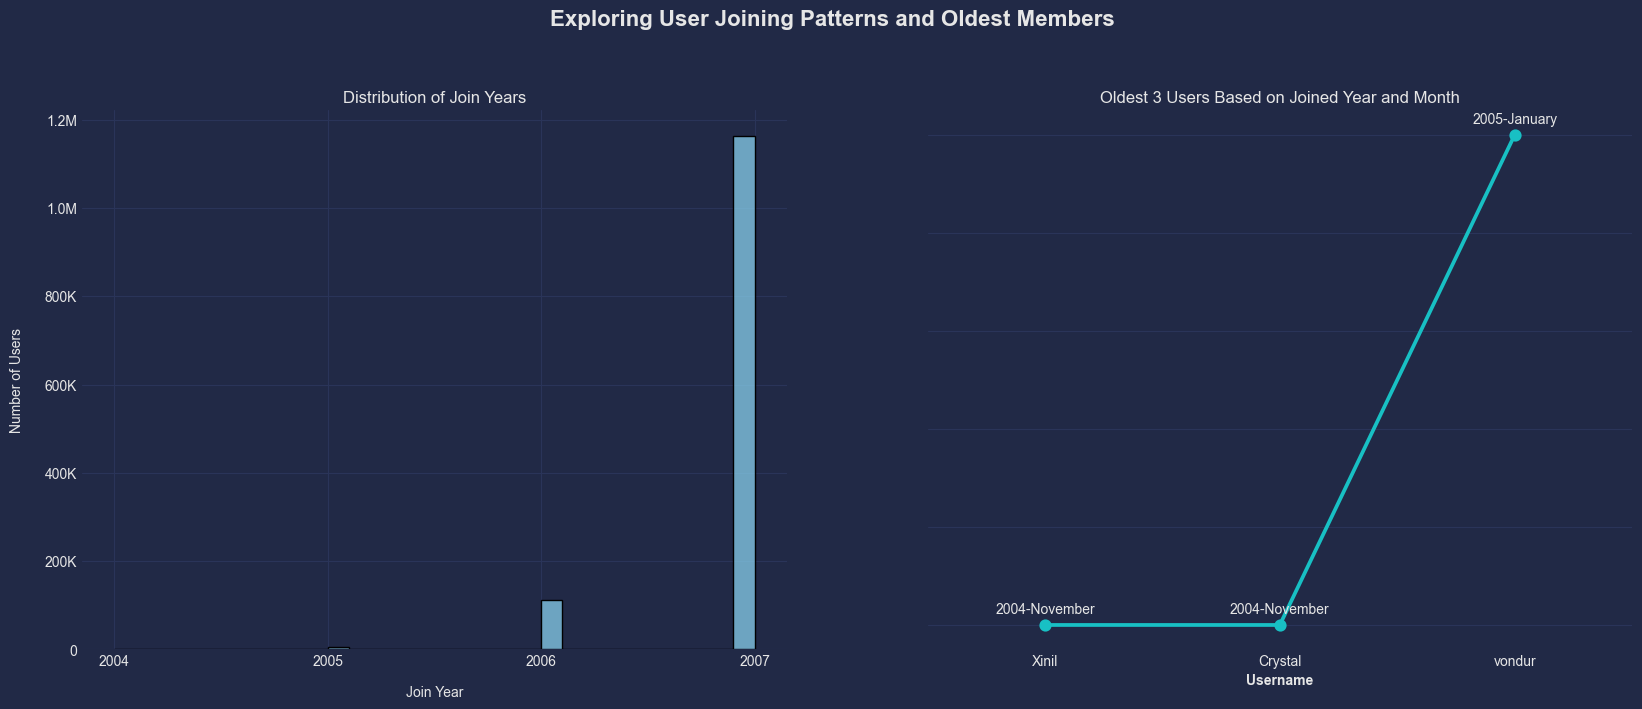

In [50]:
from matplotlib.ticker import MaxNLocator

# Convert 'Joined' column to datetime and extract the year
user['Joined'] = pd.to_datetime(user['Joined'])
joined_year = user['Joined'].dt.year.astype(int)


# Plot the distribution of join years
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 7))
formatter = FuncFormatter(million_formatter)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.histplot(joined_year, bins=30, kde=False, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Join Years')
ax1.set_xlabel('Join Year', labelpad=12)
ax1.set_ylabel('Number of Users', labelpad=15)
ax1.yaxis.set_major_formatter(formatter)

# Find the oldest join dates for each user
oldest_user_dates = user.groupby('Username')['Joined'].min()

# Find the top 3 oldest users
top_3_oldest_users = oldest_user_dates.nsmallest(3)

# Visualize the oldest 3 users with a point plot
ax2 = sns.pointplot(x=top_3_oldest_users.index, y=top_3_oldest_users.dt.year, markers='o')

# Add annotations for each point with year and month
for username in top_3_oldest_users.index:
    date = top_3_oldest_users.loc[username]
    annotation_text = f"{date.year}-{date.strftime('%B')}"  # e.g., "2022-January"
    ax2.annotate(annotation_text, (top_3_oldest_users.index.get_loc(username), date.year), 
                 textcoords="offset points", xytext=(0, 8), ha='center')  # Adjusted xytext
ax2.set_ylabel('')
ax2.set_yticklabels('')

ax2.set_title('Oldest 3 Users Based on Joined Year and Month')
ax2.set_xlabel('Username', fontdict={'weight': 'bold'})

fig.suptitle('Exploring User Joining Patterns and Oldest Members', fontsize=16 , y=1.01,
              fontweight='bold', verticalalignment='center', horizontalalignment='center')
plt.subplots_adjust(hspace=0.4)
plt.show()


 🔬The data indicates that over the years, the platform's popularity has consistently grown, reaching its peak in 2007 with nearly **1.2 million** new users joining. Additionally, we observe the profiles of the initial three users who joined the platform during its inception in 2004 and early 2005.

> Fun Fact 👀 : The user `xinil` is actually The founder of the platform . 


> #### **<center> 👩‍💻The Otaku Test : How Much Time Spent on Watching Anime ?<center/>**

This section aims to examine the average user's watching ratio to provide insights into user behavior on the platform and the habits of anime enthusiasts overall.

In [51]:
# GROUP BY TOP 10 COMPLETED & TOTAL ENTRIES :
user[[ 'Total Entries', 'Completed', 'Days Watched']] = user[[ 'Total Entries', 'Completed', 'Days Watched']].astype(int)
top_10_ActiveUsers = user[['Username', 'Total Entries', 'Completed', 'Days Watched', 'Gender']].drop_duplicates().groupby('Username').head(10)

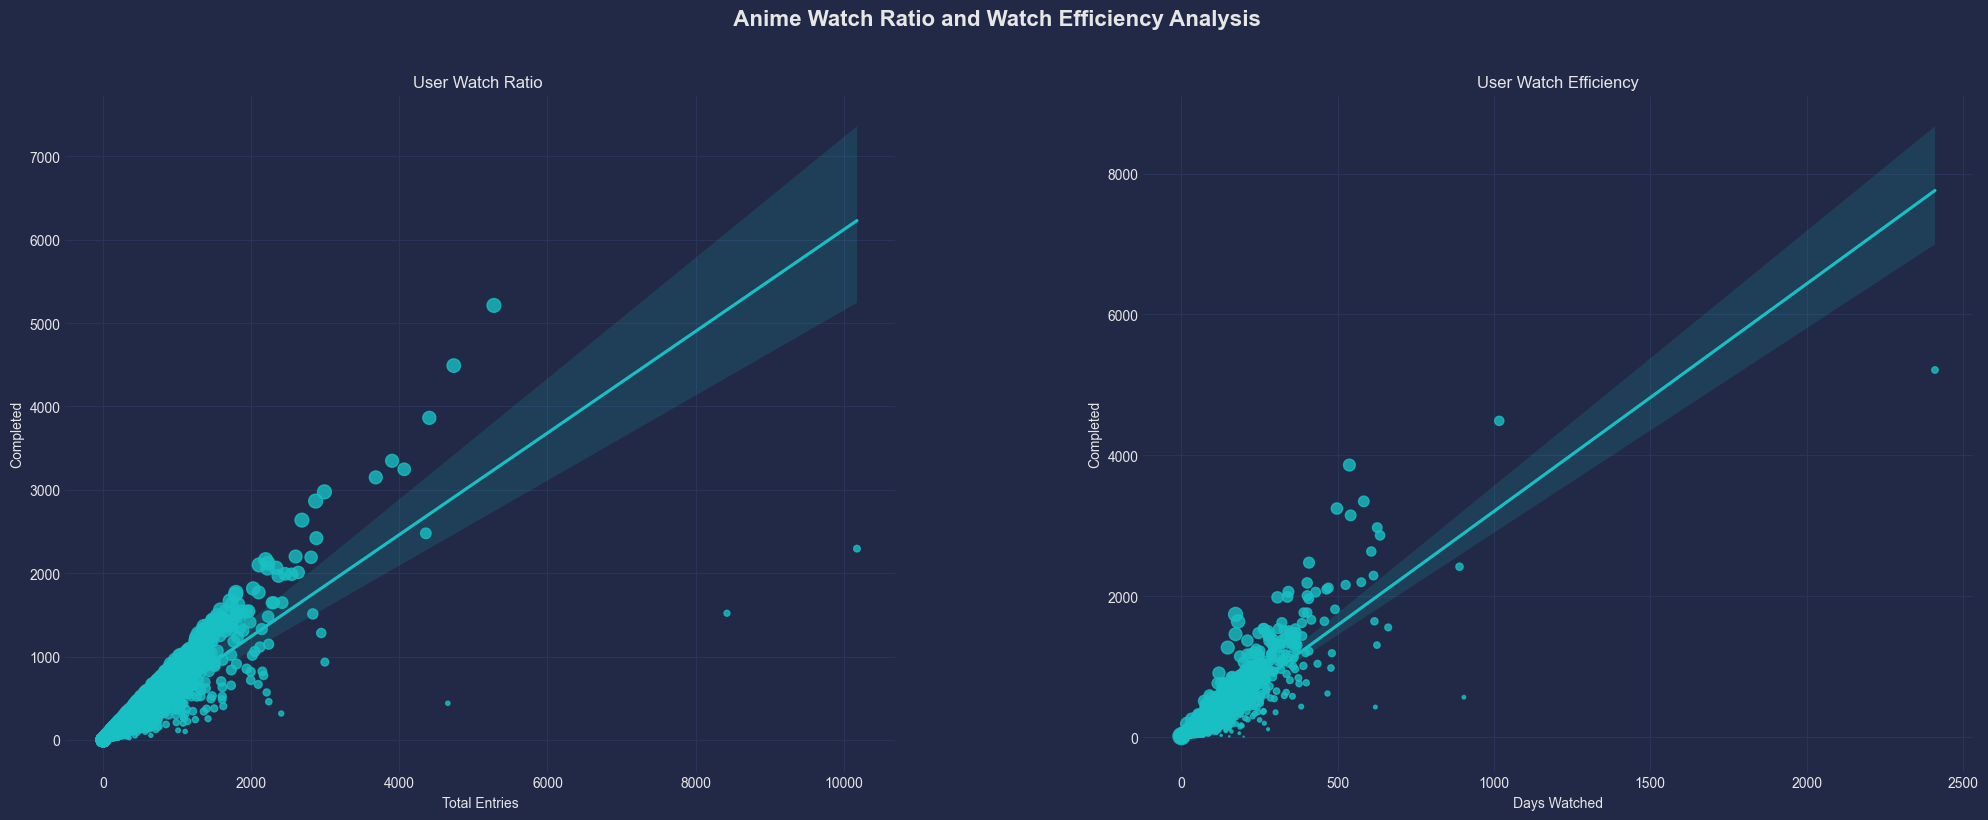

 The Most Active User : 
Username               zygreal
Total Entries            10178
Completed                 5212
Days Watched              2410
Gender              Non-Binary
Watch Ratio                1.0
Watch Efficiency           inf
dtype: object


,Username,Total Entries,Completed,Days Watched,Gender,Watch Ratio,Watch Efficiency
0,Xinil,399,233,142,Male,0.583960,1.640845
2,vondur,138,94,73,Male,0.681159,1.287671
4,Amuro,392,298,142,Male,0.760204,2.098592
6,jaames,19,16,12,Male,0.842105,1.333333
8,marvin_9martian,125,57,36,Female,0.456000,1.583333
...,...,...,...,...,...,...,...
1149712,headspinnerxxx,1,1,0,Male,1.000000,inf
1164450,Shana92,160,53,27,Female,0.331250,1.962963
1171272,ScienceNinja,2,1,2,Male,0.500000,0.500000
1227209,bob-the-kitty,1,0,0,Female,0.000000,NaN


In [52]:
# Calculate Watch Ratio
top_10_ActiveUsers['Watch Ratio'] = top_10_ActiveUsers['Completed'] / top_10_ActiveUsers['Total Entries']

# Calculate Watch Efficiency
top_10_ActiveUsers['Watch Efficiency'] = top_10_ActiveUsers['Completed'] / top_10_ActiveUsers['Days Watched']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


# Subplot 3: Watch Ratio with Regression Line

sns.regplot(x='Total Entries', y='Completed', data=top_10_ActiveUsers, scatter_kws={'s': top_10_ActiveUsers['Watch Ratio'] * 100}, ax=ax1)
ax1.set_title('User Watch Ratio ')
ax1.set_xlabel('Total Entries')
ax1.set_ylabel('Completed')

# Subplot 4: Watch Efficiency with Regression Line
sns.regplot(x='Days Watched', y='Completed', data=top_10_ActiveUsers, scatter_kws={'s': top_10_ActiveUsers['Watch Efficiency'] * 10} , ax=ax2)
ax2.set_title('User Watch Efficiency')
ax2.set_xlabel('Days Watched')
ax2.set_ylabel('Completed')



# Add a common title to the entire set of subplots
plt.suptitle(' Anime Watch Ratio and Watch Efficiency Analysis', y=1.02, fontsize=16, fontweight='bold')


plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
# VISUALIZING THE MOST ACTIVE USER ON THE PLATFORM:
print(f' The Most Active User : \n{top_10_ActiveUsers.max()}')
top_10_ActiveUsers

In the analysis provided, we introduced two metrics, `Watch Efficiency` and `Watch Ratio`, aimed at understanding the behavior of MAL users.

- `Watch Efficiency`: measures the number of anime completed relative to the total days spent watching, indicating how much anime users watch within a given timeframe.

 - On the other hand, `Watch Ratio` compares the number of anime completed to the total number of anime added to the user's list, reflecting how much of the anime on their list they actually watch.
 - We also have printed user `zygreal` the Most active user in the dataset , displaying their watching efficiency and ratio

> Our observation suggests that users who spend more days watching anime tend to complete a greater number of anime. Additionally, those with a higher total number of entries in their list are more likely to complete more anime. We intend to examine the linear relationship between these variables using Pearson's correlation test.   
---

> Testing The linear relationship 

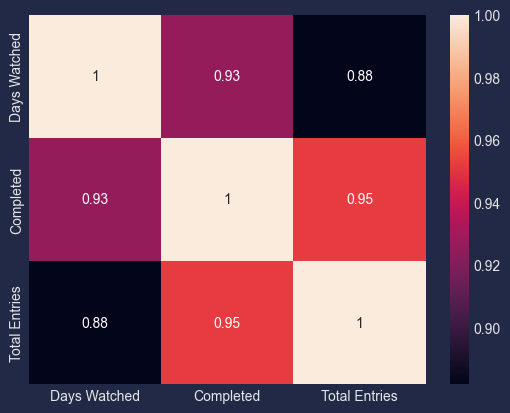

In [53]:
correlation_matrix = user[['Days Watched' , 'Completed', 'Total Entries']].corr(method='spearman')

sns.heatmap(data=correlation_matrix , annot=True)
plt.show()

> 🔴The correlation test results reveal a robust positive correlation between the number of entries and the number of animes completed. This indicates that as users add more titles to their list, they also tend to watch more. Similarly, a strong relationship exists between the number of completed anime and the days spent watching. In essence, the more time users dedicate to watching anime, the higher the likelihood of completing more titles.

> Furthermore, the correlation between days watched and total entries is also significant, with a correlation coefficient of `0.88`. This suggests that as users add more anime to their list, they are inclined to spend more days watching anime, likely due to the increased options available in their list.  
---

>#### **<center>Analyzing Users Favorites <center/>**
Upon analyzing the typical user's activity patterns on the platform, we'll delve into the most popular titles. which anime titles are fans consistently rewatching? which Anime title has tend to get the highest rating among user ?

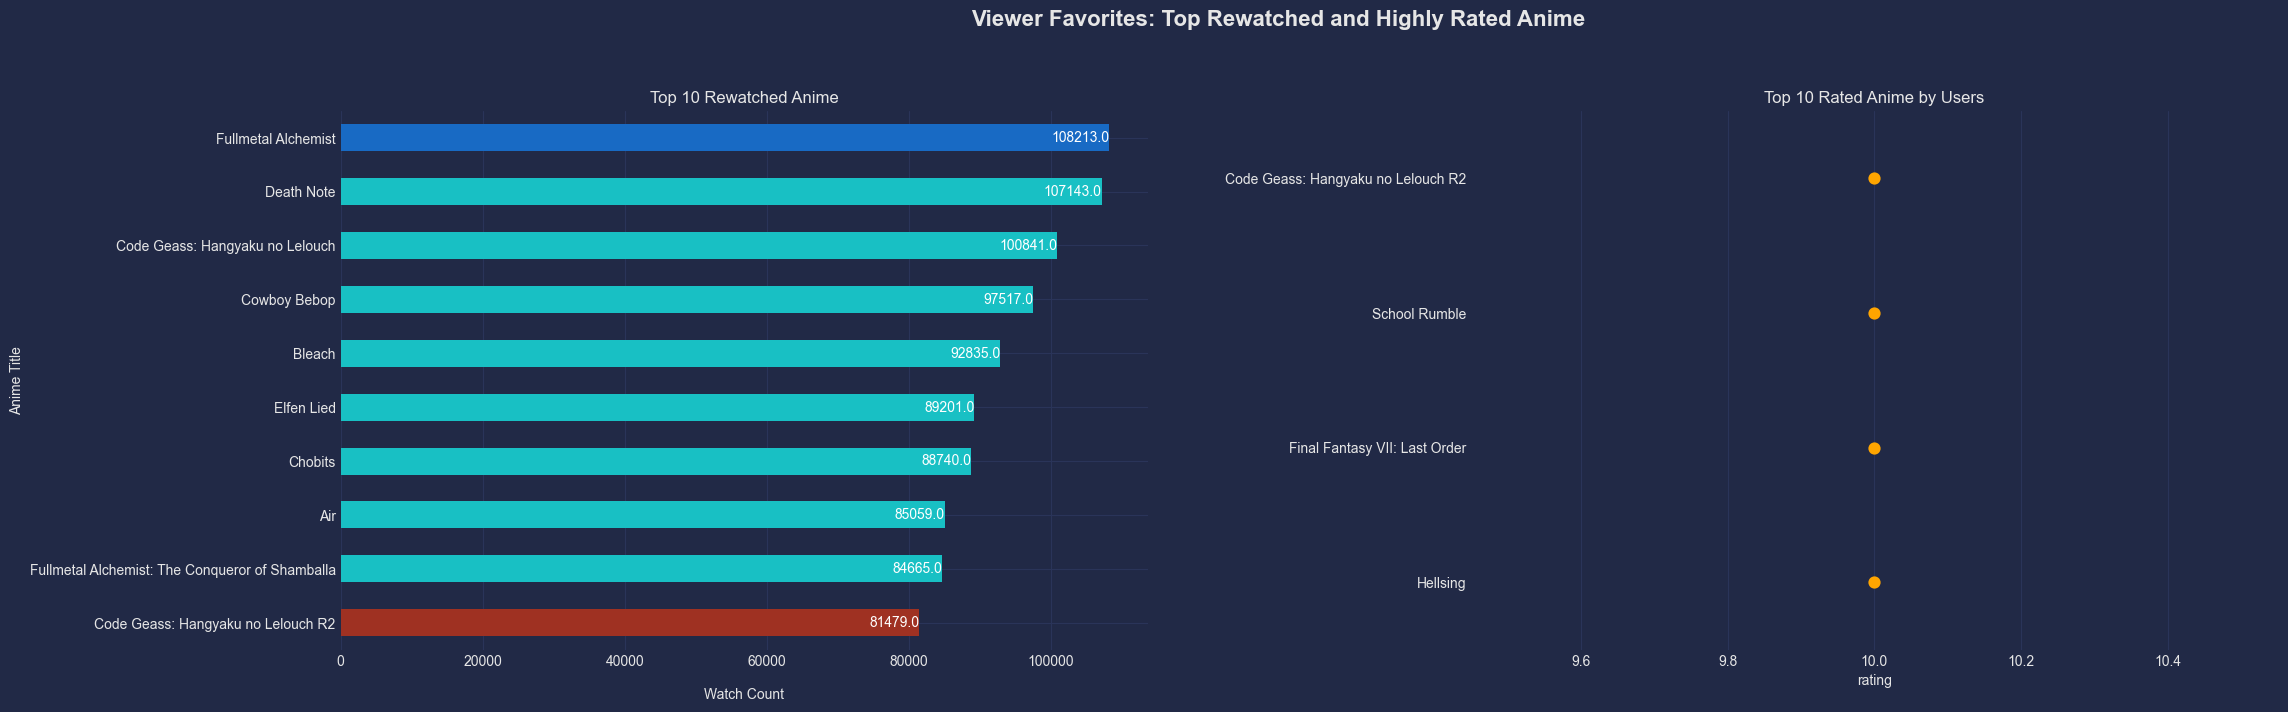

In [54]:
user.loc[:, 'Rewatched'] = user['Rewatched'].astype(int)
rewatch_counts = user.groupby('Anime Title')['Rewatched'].sum()

top_10_rewatched = rewatch_counts.sort_values(ascending=False).head(10)[::-1]  # Reversing the order
top_10_rated_animes = user.sort_values(by='rating', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
bars = top_10_rewatched.plot(kind='barh', color='#18C0C4', ax=ax1)  # Using barh for horizontal bar chart

index_longest = top_10_rewatched.idxmax()
index_shortest = top_10_rewatched.idxmin()

bars.patches[top_10_rewatched.index.get_loc(index_longest)].set_facecolor('#186AC4')
bars.patches[top_10_rewatched.index.get_loc(index_shortest)].set_facecolor('#9f3122')
for i, v in enumerate(top_10_rewatched):
    bars.text(v + 0.1, i, str(v), color='white', va='center', ha='right')
ax1.set_xlabel('Watch Count', labelpad=14)
ax1.set_ylabel('Anime Title')  # Adding y-label
ax1.set_title('Top 10 Rewatched Anime')

sns.pointplot(x='rating', y='Anime Title', data=top_10_rated_animes, join=False, color='orange', ax=ax2)
ax2.set_title('Top 10 Rated Anime by Users')
ax2.set_ylabel('')


plt.suptitle('Viewer Favorites: Top Rewatched and Highly Rated Anime', 
             y=1.01,verticalalignment='center' , horizontalalignment='center', fontsize=16, fontweight='bold')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()


Testing  The relationship Between Rewatched & Rating . 

           Rewatched    rating
Rewatched   1.000000  0.097417
rating      0.097417  1.000000


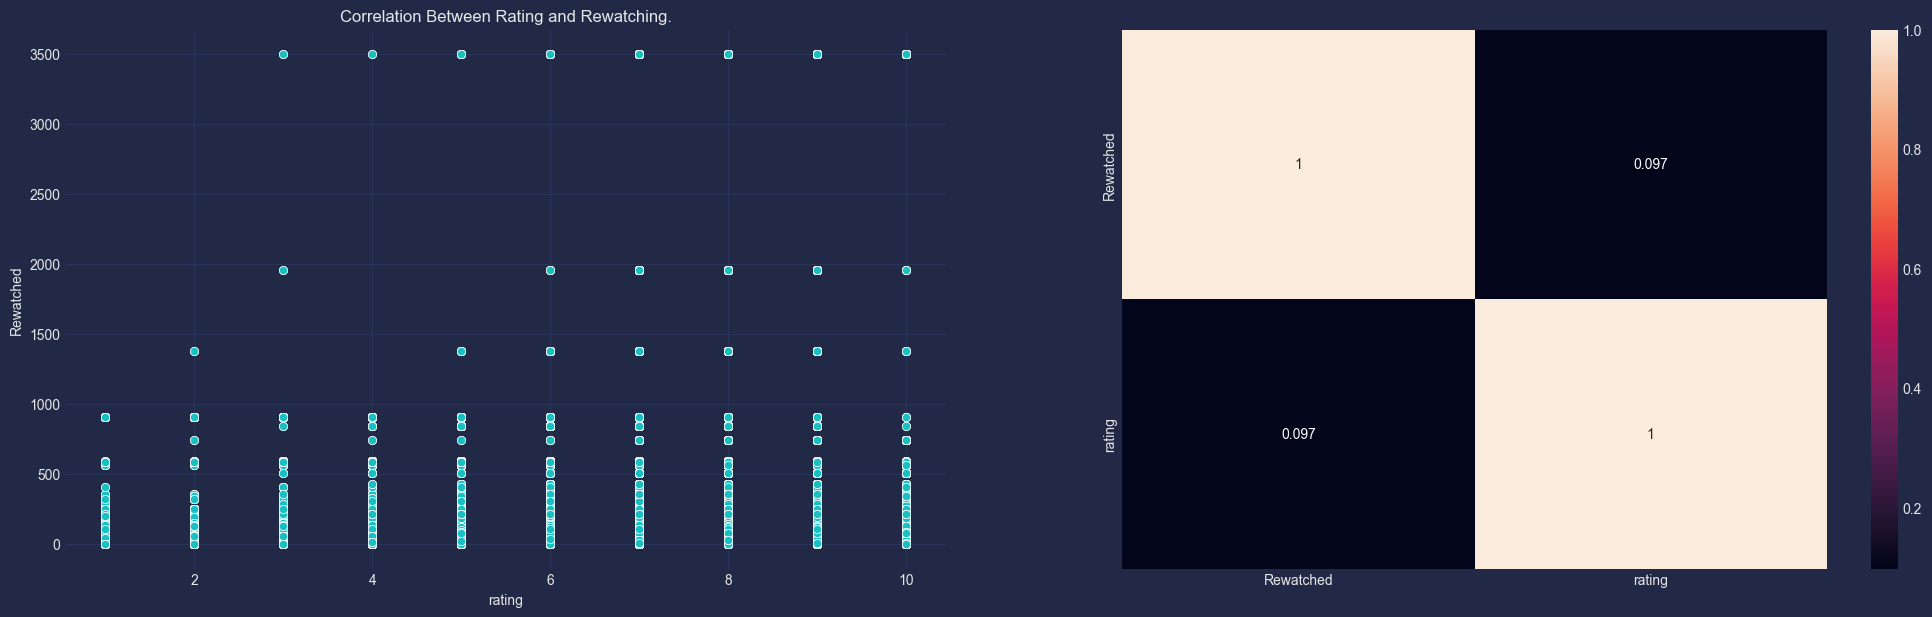

In [57]:
# Converting floats to int.
rewatched_rating_filtered = user[['rating', 'Rewatched']].astype(int)

# Calculate mean for each unique combination of 'Rewatched' and 'rating'
unique_values = rewatched_rating_filtered[['Rewatched', 'rating']].drop_duplicates()

# CHECKING FOR CORRELATION USING PEARSON METHOD.
correlation_matrix = unique_values.corr(method='spearman')

# PRINTING THE VALUES.
print(correlation_matrix)

# PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))

sns.scatterplot(data=user, x='rating', y='Rewatched' , ax=ax1)
ax1.set_title('Correlation Between Rating and Rewatching.')

sns.heatmap(data=correlation_matrix,annot=True ,ax=ax2)
plt.show()


The correlation test results indicate:

The discovery of a strong positive correlation between the frequency of anime rewatches and the overall rating, with a correlation coefficient of `0.97`.
This suggests that as users rewatch a show more often, they are likely to give it a higher rating.

> #### **<center> Gender Analysis: Contrasting Otaku Characteristics Across Genders <center/>👩👨**  
---

 ##### **<center> Analyzing The Average Watching Rate : Gender Anlaysis  <center/>**
<center> How much on average , Anime Fans spent watching anime <center/>

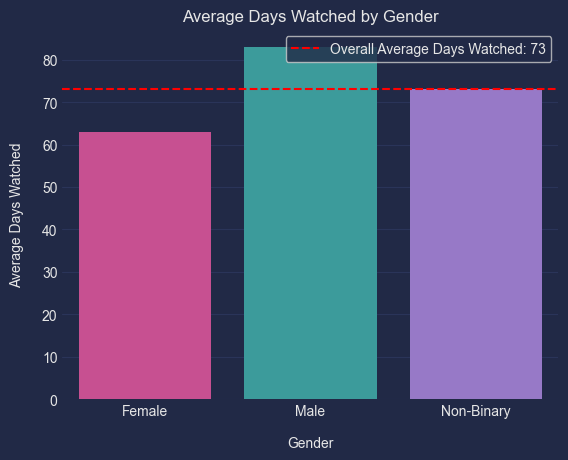

In [60]:
# Calculate average days watched by gender
average_days_watched_by_gender = top_10_ActiveUsers.groupby('Gender')['Days Watched'].mean().astype('int').round()

# Define custom color palette with colors assigned to each gender
custom_palette = {'Male': '#2cabab', 'Female': '#db3c93', 'Non-Binary':'#946cd4'}

# Create bar plot and hue by gender 
sns.barplot(x=average_days_watched_by_gender.index, y=average_days_watched_by_gender.values, hue=average_days_watched_by_gender.index, palette=custom_palette)
plt.axhline(y=average_days_watched_by_gender.mean(), color='r', linestyle='--', label=f'Overall Average Days Watched: {average_days_watched_by_gender.mean():.0f}')
plt.title('Average Days Watched by Gender')
plt.xlabel('Gender', labelpad=13)
plt.ylabel('Average Days Watched', labelpad=13)
plt.legend()
plt.show()


Based on the dataset, **females** typically watch anime for approximately `62 days`, whereas **males** watch for just over `80 days` on average. Irrespective of gender, the average time spent watching anime by **all fans** is approximately `73 days`.   

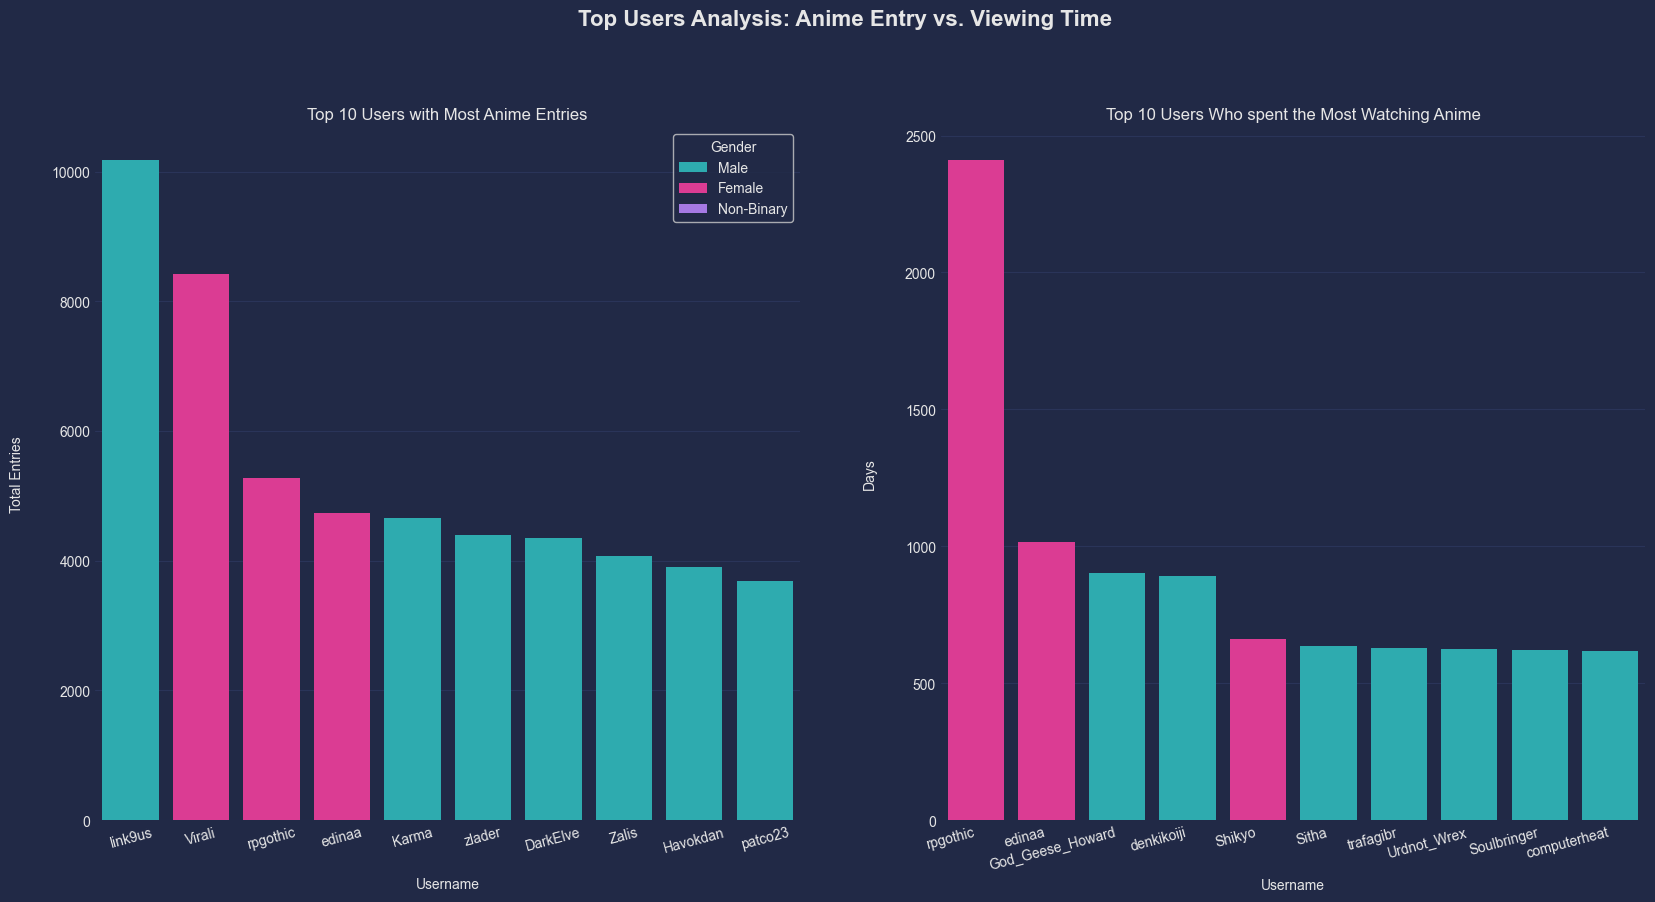

In [61]:
# Drop duplicates based on unique 'Username' and 'Total_Entries'
unique_users_entries = user.drop_duplicates(['Username', 'Total Entries'])
unique_users_DaysWatched = user.drop_duplicates(['Username', 'Days Watched'])

# Pick the top 10 users based on 'Total_Entries'
top_users = unique_users_entries.nlargest(10, 'Total Entries')
top_users_Days_watched = unique_users_DaysWatched.nlargest(10, 'Days Watched')

# Get unique gender values in the correct order
gender_order = user['Gender'].unique()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
sns.barplot(x='Username', y='Total Entries', hue='Gender', data=top_users, ax=ax1, hue_order=gender_order)
ax1.set_title('Top 10 Users with Most Anime Entries')
ax1.set_xlabel('Username',labelpad=15.9)
ax1.set_ylabel('Total Entries', labelpad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

sns.barplot(x='Username', y='Days Watched', hue='Gender', data=top_users_Days_watched, ax=ax2, hue_order=gender_order)
ax2.set_title('Top 10 Users Who spent the Most Watching Anime')
ax2.set_xlabel('Username')
ax2.set_ylabel('Days', labelpad=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
ax2.legend().set_visible(False)

# Move the legend outside the subplots
ax1.legend(loc='upper right', title='Gender')
fig.suptitle('Top Users Analysis: Anime Entry vs. Viewing Time', fontsize=16, y=1, fontweight='bold', verticalalignment='center', 
             horizontalalignment='center')
plt.show()


Among the top 10 users with the longest watching streak, 7 are male while only 3 are female. Notably, among users with the longest streak of days watching anime, the female user `rgpgothic` stands out with over 2000 days of viewing. Conversely, when considering the number of entries per list, males outnumber females, with 7 males compared to 3 females. Particularly, user `link9us` boasts over 10,000 anime in their list.

In [62]:
# Step 1: Create a copy of the DataFrame to avoid modifying the original
user_copy = user.copy()

# Step 2: Split the 'Genres' column into individual genres
user_copy['Genres'] = user_copy['Genres'].str.split(',')

# Step 3: Explode the DataFrame to have one row per genre
user_exploded = user_copy.explode('Genres')

# Step 4: Filter data for each gender without modifying the original DataFrame
male_data = user_exploded[user_exploded['Gender'] == 'Male']
female_data = user_exploded[user_exploded['Gender'] == 'Female']


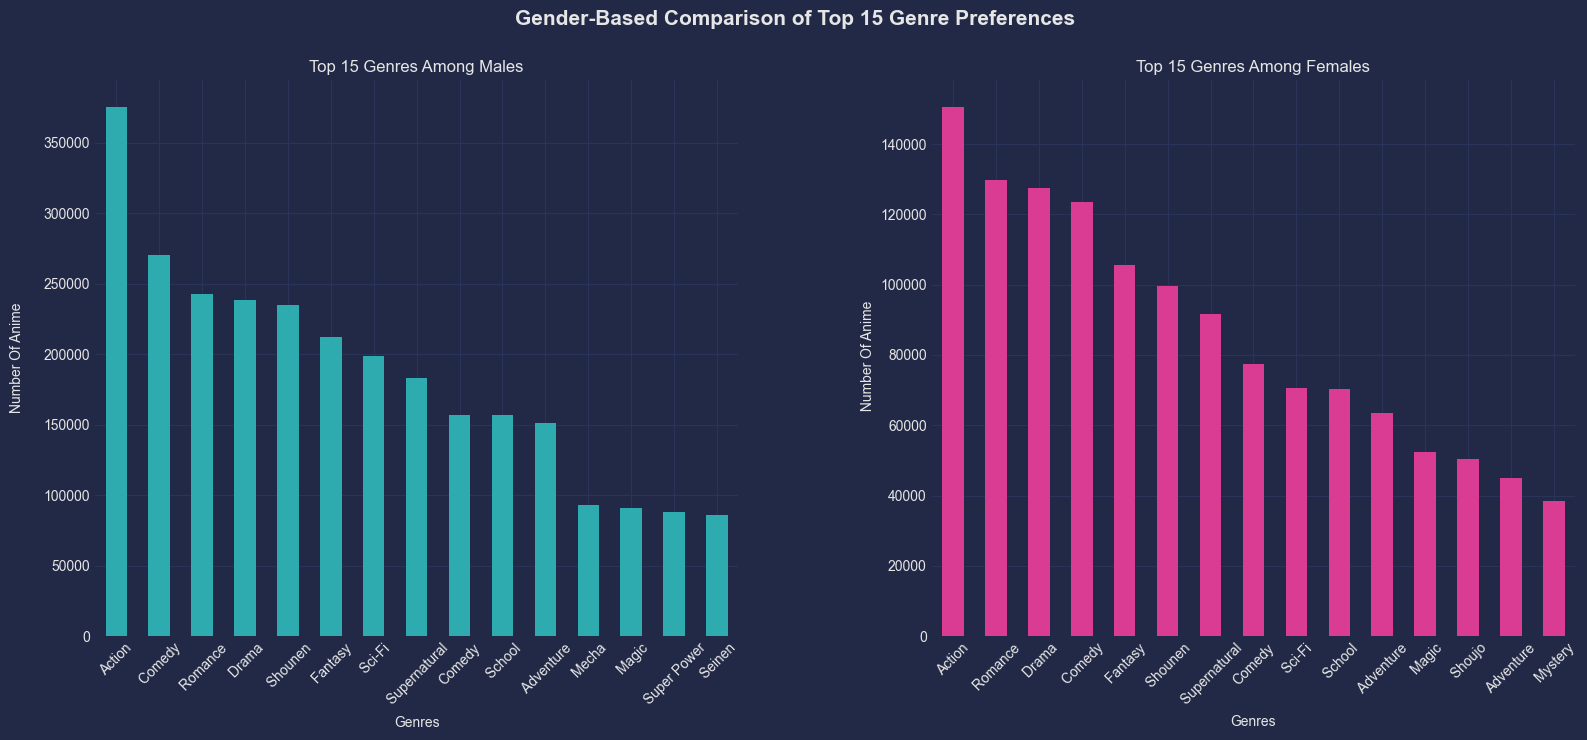

In [63]:
# Create a figure and axes with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Calculate genre counts for males and females
male_genre_counts = male_data['Genres'].value_counts().head(15)
female_genre_counts = female_data['Genres'].value_counts().head(15)


# Plot for males
male_genre_counts.plot(kind='bar', ax=axes[0], color='#2eabaf')
axes[0].set_title('Top 15 Genres Among Males', fontsize=12)
axes[0].set_ylabel('Number Of Anime',labelpad=14)
axes[0].tick_params(axis='x', labelrotation=45)

# Plot for females
female_genre_counts.plot(kind='bar', ax=axes[1], color='#db3c93')
axes[1].set_title('Top 15 Genres Among Females', fontsize=12)
axes[1].set_ylabel(' Number Of Anime')
axes[1].tick_params(axis='x', labelrotation=45) 

# Adjust layout
plt.tight_layout()
plt.suptitle('Gender-Based Comparison of Top 15 Genre Preferences', fontsize=15, fontweight='bold', y=1.05)

plt.subplots_adjust(wspace=0.3, hspace=0.8)

# Show the plot
plt.show()


It is observed that `Action` stands out as the most popular genre across all genders. However, `Romance` appears to be more prevalent among females than males, while `Comedy` seems to be favored more by males than females. Additionally, it is noteworthy that the distribution of numbers is influenced by the larger male user population in this dataset.

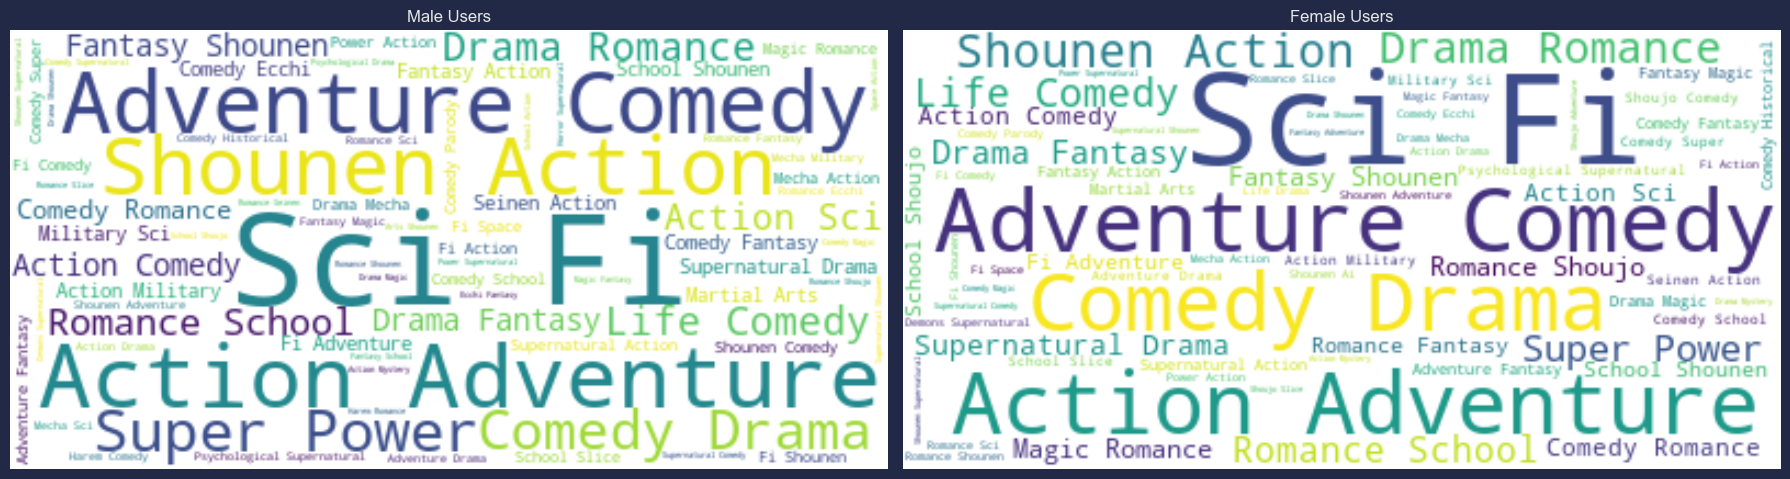

In [64]:
from wordcloud import WordCloud

# Drop rows with missing values in 'Genres' column
user = user.dropna(subset=['Genres'])

# Splitting the genres and creating a list of all genres
all_genres = [genre.strip() for sublist in user['Genres'].str.split(',') for genre in sublist]

# Joining all the genres into a single string separated by space
all_genres_text = ' '.join(all_genres)



# Assuming 'genres' column contains comma-separated genres for each anime

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))



# Plotting the word cloud for male users
wordcloud_male = WordCloud(width=400, height=200, background_color='white').generate(' '.join(user[user['Gender'] == 'Male']['Genres']))
axes[0].imshow(wordcloud_male, interpolation='bilinear')
axes[0].set_title('Male Users')
axes[0].axis('off')

# Plotting the word cloud for female users
wordcloud_female = WordCloud(width=400, height=200, background_color='white').generate(' '.join(user[user['Gender'] == 'Female']['Genres']))
axes[1].imshow(wordcloud_female, interpolation='bilinear')
axes[1].set_title('Female Users')
axes[1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


The word cloud plot (or text frequency plot) above delves into the nuances of gender preferences regarding genres. While similarities in taste are evident between both genders with `Action Adventure` being popular among both groups, notable differences also emerge. For instance, `Shounen , Action` are more prevalent among males, whereas `Comedy Drama` garners more popularity among females. 

> #### **<center>  ⭐⭐⭐ Observing The Overall Rating Behavior : Gender Wise <center/>**

We will first inspect the overall mean score given by users 

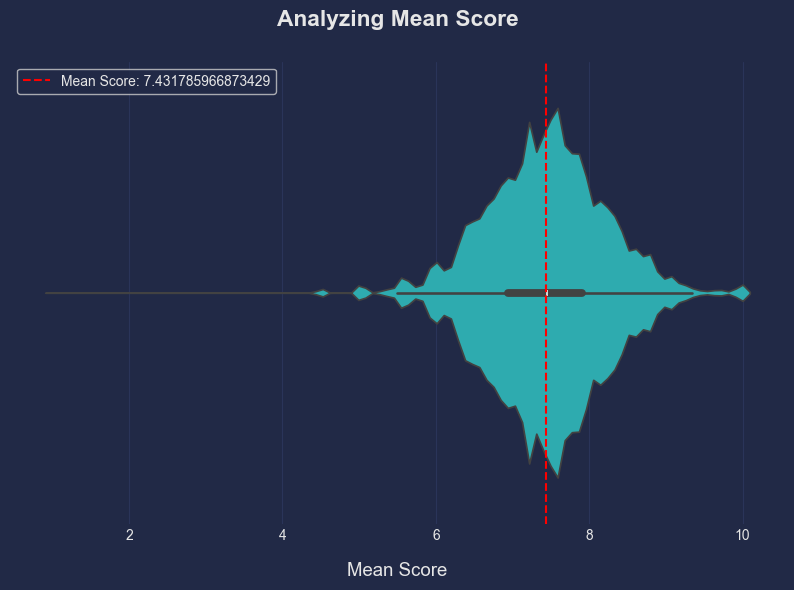

In [65]:

plt.figure(figsize=(10,6))
# Violin plot with mean score annotation
sns.violinplot(data=user, x='Mean Score')
mean_scores = user['Mean Score'].mean()
plt.title('Analyzing Mean Score', fontsize=16.4, fontweight='bold', y=1.06)
plt.xlabel('Mean Score',labelpad=14, fontsize=13.4)
plt.axvline(mean_scores, color='red', linestyle='--', label=f'Mean Score: {mean_scores}')
plt.legend()

# Show the plot
plt.show()


According to our data : The Average score given by the overall users is around `7` . 
> We Will next look for The rating behavior based on each gender in our dataset . is it the same for all genders?👀

> ##### **<center>Analyzing Rating Per Gender<center/>**

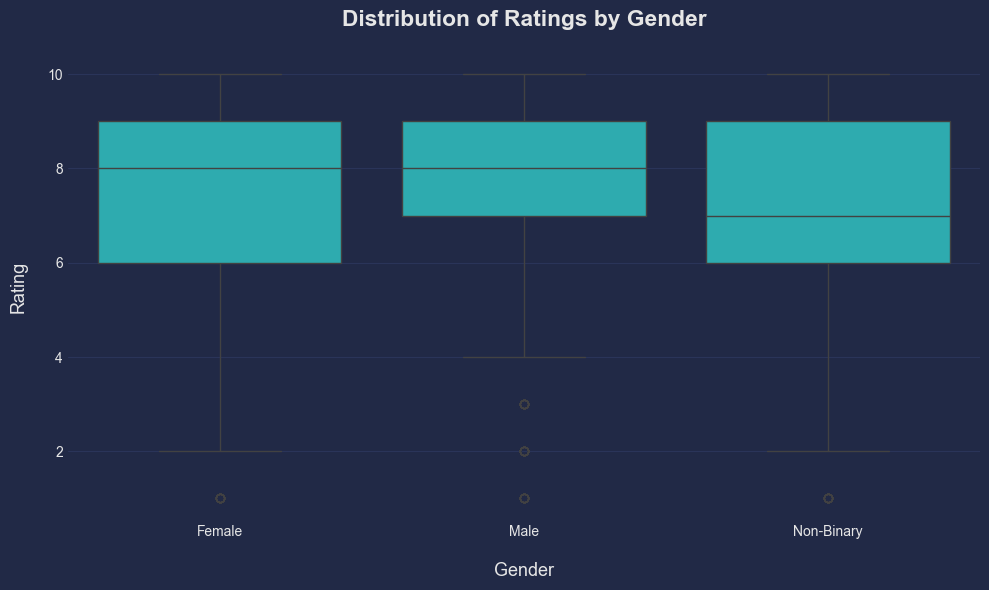

In [66]:
# Convert 'Gender_no' to int
user['Gender_no'] = user['Gender_no'].astype(int)

# Create a figure
plt.figure(figsize=(10, 6))

# Visualize the distribution of ratings within each gender using boxplots
sns.boxplot(x='Gender_no', y='rating', data=user)
plt.title('Distribution of Ratings by Gender', fontsize=16.4, fontweight='bold', y=1.04)
plt.xlabel('Gender', labelpad=16.9, fontsize=13)
plt.ylabel('Rating', labelpad=14, fontsize=13)
plt.xticks([0, 1, 2], ['Female', 'Male', 'Non-Binary'])

plt.tight_layout()
plt.show()


> ☑️The boxplot suggests that:

- Males and non-binary individuals have slightly higher median ratings than females.
- The spread of ratings (IQR) is wider for males and non-binary individuals.
- There are more outliers in ratings among males and non-binary individuals.

 
> In summary, the overall distribution tells us that , while there may not be a significant difference in ratings among genders, there could be more variability within certain gender groups compared to others. We will test this theory forward in the next section

> Comparing Ratings Across Gender Groups

We wanted to see if there are noticeable differences in how different gender groups (Female, Male, Non-Binary) rate anime. Using a statistical test called ANOVA, here's what we found:

`What We Discovered:`

There are significant differences in how Female, Male, and Non-Binary groups rate anime (p < 0.05).
Key Stats to Know:

`F-Statistic:`

This number shows how big these differences are.
Higher values mean bigger differences between groups.
p-Value:

This tells us how likely it is that these differences happened by chance.
A low p-value (close to zero) means the differences are probably real.

> In Conclusion:

>Our analysis strongly suggests that there are real and important differences in how each gender group rates anime.

In [67]:
# Perform an ANOVA to compare mean ratings among all three gender groups
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model
model = ols('rating ~ C(Gender_no)', data=user).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Interpret the results
alpha = 0.05
p_value_anova = anova_table['PR(>F)'][0]
if p_value_anova < alpha:
    print('The difference in mean ratings among all three gender groups is statistically significant.')
else:
    print('There is no significant difference in mean ratings among all three gender groups.')



                    sum_sq         df           F         PR(>F)
C(Gender_no)  1.481506e+03        2.0  275.609326  2.138628e-120
Residual      3.442994e+06  1281023.0         NaN            NaN
The difference in mean ratings among all three gender groups is statistically significant.


> ### **<center> 🔗👩‍💻Conclusion & Findings<center/>**

##### **<center>After analyzing the anime data in the previous section, this section focuses on user-based analysis. We leveraged insights from the previous section, including the top 10 most popular shows.<center/>**

**In this project, we accomplished the following:**

- **`🔄️Data Loading and Cleaning`**: We loaded and inspected the data for errors and inconsistencies, subsequently cleaning it to ensure suitability for analysis. We utilized various methods, including the MICE algorithm and the GeoNames API.

- **`📊Exploratory Data Analysis (EDA) and Visualization`**: During this phase, we addressed the initial project questions:
  1. ###### `Average Time Spent Watching Anime`: We discovered variations in viewing habits among gender groups but found an overall average of approximately **73** days spent watching anime.
  2. ###### `Preferred Genres by Gender`: We identified similarities and differences in genre preferences between males and females. While action was popular among both groups, genres like "Comedy Drama" were favored by females, whereas "Shounen Action" was more popular among males.
  3. ###### `Top 10 Rewatched Anime`: By visualizing the top 10 rewatched anime titles, we found that some titles overlapped with those defined as the top-rated anime of all time in the previous section, such as "Fullmetal Alchemist" and "Bleach." We also explored the relationship between the "Rewatched" and "Rating" columns.
  
> Additionally, we uncovered intriguing insights, including the relationship between gender and rating:
- Slight differences exist in the average rating given by different gender groups.
- We visualized the top 10 users with the highest number of days spent watching anime, categorized by gender.